In [ ]:
pip install torchinfo

In [ ]:
# !pip install -r requirements.txt

In [ ]:
# !pip install wordcloud torchinfo datasets transformers

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
folder_path = '/content/gdrive/My Drive/NLP/'
os.chdir(folder_path)
#------------------------------------------------------------------------------------------#
import json
import re
import pickle
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)
import time
#------------------------------------------------------------------------------------------#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
from wordcloud import WordCloud
import seaborn as sns
from tqdm.auto import tqdm
from dataclasses import dataclass, field
#------------------------------------------------------------------------------------------#
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords;
#------------------------------------------------------------------------------------------#
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
#------------------------------------------------------------------------------------------#
from datasets import Dataset, DatasetDict, load_dataset
from transformers import (
    AutoTokenizer,
    BertForSequenceClassification, BertTokenizer,
    XLNetForSequenceClassification, XLNetTokenizer,
    get_linear_schedule_with_warmup, DataCollatorWithPadding,
    AutoModelForSequenceClassification
)
#------------------------------------------------------------------------------------------#
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from torchinfo import summary

2025-06-12 09:09:37,555 - INFO - NumExpr defaulting to 12 threads.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
class DataCollector:
    def __init__(self,
                 file_path_DataSet_Misinfo_FAKE='DataSet_Misinfo_FAKE.csv',
                 file_path_DataSet_Misinfo_TRUE='DataSet_Misinfo_TRUE.csv'):
        self.file_path1 = file_path_DataSet_Misinfo_FAKE
        self.file_path2 = file_path_DataSet_Misinfo_TRUE
        self.df = None
        self.inference_df = None

    def load_data(self):
        df1 = pd.read_csv(self.file_path1); df1['label'] = 0
        logging.info(f"Đã tải {len(df1)} hàng dữ liệu FAKE.")

        df2 = pd.read_csv(self.file_path2); df2['label'] = 1
        logging.info(f"Đã tải {len(df2)} hàng dữ liệu TRUE.")

        df = pd.concat([df1, df2], ignore_index=True)
        logging.info(f"Đã nối hai dữ liệu lại với nhau, tổng số hàng: {len(df)}")

        df.drop(columns=['Unnamed: 0'], inplace=True)
        logging.info("Đã xóa cột 'Unnamed: 0'.")

        initial_rows_na = len(df)
        df.dropna(subset=['text'], inplace=True)
        logging.info(f"Đã xóa {initial_rows_na - len(df)} hàng có giá trị NaN trong cột 'text'.")

        initial_rows_dup = len(df)
        df.drop_duplicates(subset=['text'], inplace=True)
        logging.info(f"Đã xóa {initial_rows_dup - len(df)} hàng trùng lặp.")

        self.df = df

    def create_inference_df(self, num_samples_per_class=2):
        self.df['text_length'] = self.df['text'].astype(str).apply(len)
        median_length = self.df['text_length'].median()
        inference_samples = []
        indices_to_remove = []
        for label in self.df['label'].unique():
            class_df = self.df[self.df['label'] == label]
            # Filter for text lengths within tolerance and sample
            filtered_samples = class_df[
                (class_df['text_length'] >= median_length - 50) &
                (class_df['text_length'] <= median_length + 50)
            ].sample(n=min(num_samples_per_class, len(class_df)), random_state=42)
            inference_samples.append(filtered_samples)
            indices_to_remove.extend(filtered_samples.index.tolist())
        self.df.drop(columns=['text_length'], inplace=True)
        self.inference_df = pd.concat(inference_samples)
        self.df.drop(index=indices_to_remove, inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        logging.info(f"Đã tạo inference_df với {len(self.inference_df)} mẫu.")

    def print_info(self):
        print("\n\n----------THÔNG TIN DATAFRAME----------")
        print(self.df.info())
        print("\n\n--------------PHÂN BỐ LỚP--------------")
        print(self.df['label'].value_counts())


In [ ]:
class DataPreprocessor:
    def __init__(self, df=None):
        if df is not None:
            self.df_ML = df.copy()
            self.df_DL = df.copy()

    def preprocess_text(self, df=None):
        stop_words = set(stopwords.words('english'))
        def _single_text_preprocess(text):
            text = str(text)
            # 0. Chuẩn hóa unicode
            text = unicodedata.normalize('NFKD', text)
            # 1. Bỏ các ký tự không thuộc bảng mã ASCII
            text = text.encode('ascii', 'ignore').decode('utf-8')
            # 2. Chuyển về chữ thường
            text = text.lower()
            # 3. Xóa các URL, Twitter image links, và mentions
            text = re.sub(r'(?:https?://|www\.)\S+', ' ', text)       # Xóa URL bắt đầu bằng http/https/www
            text = re.sub(r'\b_?pic\.twitter\.com\/\S+\b', ' ', text) # Xóa pic.twitter.com links
            text = re.sub(r'\b\S*@\S*\b', ' ', text)                  # Xóa từ chứa '@' (mentions)
            text = re.sub(r'(?:ha){2,}', r'ha', text)                 # Xóa từ "ha" lặp lại
            text = re.sub(r'(?:twitter){2,}', r'twitter', text)       # Xóa từ "twitter" lặp lại
            text = re.sub(r'(.)\1{2,}', r'\1\1', text)                # Xóa các ký tự lặp lại quá 2 lần
            # 4. Xóa dấu câu, ký tự đặc biệt, chỉ giữ lại chữ cái và khoảng trắng
            text = re.sub(r'[^a-zA-Z\s]', ' ', text)
            # 5. Xóa số
            text = re.sub(r'\d+', ' ', text)
            # 6. Chuẩn hóa khoảng trắng (nhiều khoảng trắng thành 1, xóa đầu/cuối)
            text = ' '.join(text.split()).strip()
            # 7. Xóa stop words
            text = ' '.join([word for word in text.split() if word not in stop_words])
            return text
        if df is None:
            logging.info("BẮT ĐẦU: Tiền xử lý văn bản cho [df_ML].")
            tqdm.pandas(desc="Tiền xử lý văn bản")
            self.df_ML['text'] =  self.df_ML['text'].astype(str).progress_apply(_single_text_preprocess)
            logging.info("HOÀN TẤT: Tiền xử lý văn bản cho [df_ML].\n\n")
        else:
            df['text'] = df['text'].astype(str).apply(_single_text_preprocess)
            return df

    def filter_by_length_text(self, lower_percentile=0.01, upper_percentile=0.99):
        logging.info("BẮT ĐẦU: Lọc theo độ dài văn bản.")
        for df_name in ['df_ML', 'df_DL']:
            df = getattr(self, df_name)
            df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()) if x.strip() else 0)
            # Tính các ngưỡng phân vị
            calculated_lower_bound = df['word_count'].quantile(lower_percentile)
            calculated_upper_bound = df['word_count'].quantile(upper_percentile)

            initial_rows = df.shape[0]
            df_filtered = df[(df['word_count'] >= calculated_lower_bound) &
                            (df['word_count'] <= calculated_upper_bound)].copy()
            rows_removed = initial_rows - df_filtered.shape[0]

            logging.info(f"     [{df_name}] - Ngưỡng dưới (P{lower_percentile*100:.0f}): {calculated_lower_bound:.0f} từ")
            logging.info(f"     [{df_name}] - Ngưỡng trên (P{upper_percentile*100:.0f}): {calculated_upper_bound:.0f} từ")
            logging.info(f"     [{df_name}] - Số lượng văn bản ban đầu: {initial_rows}")
            logging.info(f"     [{df_name}] - Số lượng văn bản sau khi lọc: {df_filtered.shape[0]}")
            logging.info(f"     [{df_name}] - Đã loại bỏ {rows_removed} hàng.")
            logging.info(f"     [{df_name}] - Tỷ lệ giữ lại: {df_filtered.shape[0] / initial_rows * 100:.2f}%")
            logging.info(f"     [{df_name}] - Thống kê độ dài văn bản sau khi lọc:")
            logging.info(f"     [{df_name}]     - Mean: {df_filtered['word_count'].mean():.2f}")
            logging.info(f"     [{df_name}]     - Min: {df_filtered['word_count'].min():.2f}")
            logging.info(f"     [{df_name}]     - 25%: {df_filtered['word_count'].quantile(0.25):.2f}")
            logging.info(f"     [{df_name}]     - 50%: {df_filtered['word_count'].median():.2f}")
            logging.info(f"     [{df_name}]     - 75%: {df_filtered['word_count'].quantile(0.75):.2f}")
            logging.info(f"     [{df_name}]     - Max: {df_filtered['word_count'].max():.2f}")
            if df_name == 'df_ML':
                logging.info(50*"=")
            setattr(self, df_name, df_filtered.drop(columns=['word_count']))
        logging.info("HOÀN TẤT: Lọc theo độ dài văn bản.\n\n")


In [ ]:
class Visualizer:
    def __init__(self, initial_df, preprocessed_df):
        self.initial_df = initial_df
        self.preprocessed_df = preprocessed_df
        self.evaluation_results = None

    def plot_text_length_boxplot(self):
        word_count_initial = self.initial_df['text'].str.count(' ') + 1
        word_count_preprocessed = self.preprocessed_df['text'].str.count(' ') + 1
        plt.figure(figsize=(15, 6))

        # Biểu đồ hộp cho độ dài văn bản ban đầu (nằm ngang)
        plt.subplot(1, 2, 1)
        sns.boxplot(x=word_count_initial, color='skyblue')
        plt.title('Độ dài văn bản TRƯỚC khi xử lý')
        plt.xlabel('Độ dài (Số lượng từ)')
        plt.grid(axis='x', alpha=0.75)

        # Biểu đồ hộp cho độ dài văn bản đã xử lý (nằm ngang)
        plt.subplot(1, 2, 2)
        sns.boxplot(x=word_count_preprocessed, color='lightcoral')
        plt.title('Độ dài văn bản SAU khi xử lý')
        plt.xlabel('Độ dài (Số lượng từ)')
        plt.grid(axis='x', alpha=0.75)

        plt.tight_layout()
        plt.show()

    def plot_text_length_distribution(self):
        word_count_initial = self.initial_df['text'].str.count(' ') + 1
        word_count_preprocessed = self.preprocessed_df['text'].str.count(' ') + 1
        # Phân phối độ dài từ trước và sau khi lọc
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(word_count_initial, bins=50, kde=True, color='skyblue')
        plt.title('Phân phối độ dài text TRƯỚC khi xử lý')
        plt.xlabel('Số lượng từ')
        plt.ylabel('Số lượng text')
        plt.grid(axis='y', alpha=0.75)

        plt.subplot(1, 2, 2)
        sns.histplot(word_count_preprocessed, bins=50, kde=True, color='lightcoral')
        plt.title('Phân phối độ dài text SAU khi xử lý')
        plt.xlabel('Số lượng từ')
        plt.ylabel('Số lượng text')
        plt.grid(axis='y', alpha=0.75)
        plt.tight_layout()
        plt.show()

    def plot_class_proportions(self):
        class_counts_initial = self.initial_df['label'].value_counts().sort_index()
        class_counts_preprocessed = self.preprocessed_df['label'].value_counts().sort_index()
        color_for_class_0 = sns.color_palette("pastel")[1]
        color_for_class_1 = sns.color_palette("pastel")[0]
        colors_to_use = [color_for_class_0, color_for_class_1]
        plt.figure(figsize=(14, 6))
        # --- Biểu đồ tròn cho DataFrame GỐC ---
        ax1 = plt.subplot(1, 2, 1)
        ax1.pie(class_counts_initial,
                labels=class_counts_initial.index,
                autopct='%1.1f%%',
                startangle=90,
                colors=colors_to_use
            )
        ax1.set_title('Tỷ lệ các lớp TRƯỚC khi xử lý', fontsize=14)
        ax1.axis('equal')
        # --- Biểu đồ tròn cho DataFrame ĐÃ TIỀN XỬ LÝ ---
        ax2 = plt.subplot(1, 2, 2)
        ax2.pie(class_counts_preprocessed,
                labels=class_counts_preprocessed.index,
                autopct='%1.1f%%',
                startangle=90,
                colors=colors_to_use
            )
        ax2.set_title('Tỷ lệ các lớp SAU khi xử lý', fontsize=14)
        ax2.axis('equal')
        plt.tight_layout()
        legend_handles = [
            Patch(facecolor=color_for_class_0, label='Lớp 0'), # Lớp 0 có màu cam
            Patch(facecolor=color_for_class_1, label='Lớp 1')  # Lớp 1 có màu xanh
        ]
        bbox_to_anchor=(1.05, 1)
        plt.legend(handles=legend_handles, title='Lớp', loc='upper left', bbox_to_anchor=(1.05, 1))

        plt.show()

    def plot_top_features(self, top_n=20, ngram_range=(1, 3)):
        tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=2000)
        tfidf_matrix = tfidf_vectorizer.fit_transform(self.preprocessed_df['text'])
        feature_names = tfidf_vectorizer.get_feature_names_out()

        # --- 1. Tính toán điểm TF-IDF trung bình cho mỗi từ/n-gram
        avg_tfidf_scores = tfidf_matrix.mean(axis=0).A1
        tfidf_df = pd.DataFrame({'feature': feature_names, 'tfidf_score': avg_tfidf_scores})
        tfidf_df = tfidf_df.sort_values(by='tfidf_score', ascending=False).head(top_n)

        # --- 2. Tính toán tần số N-gram (Count) ---
        count_vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=2000)
        count_matrix = count_vectorizer.fit_transform(self.preprocessed_df['text'])
        count_feature_names = count_vectorizer.get_feature_names_out()
        total_counts = count_matrix.sum(axis=0).A1
        count_df = pd.DataFrame({'feature': count_feature_names, 'count': total_counts})
        count_df = count_df.sort_values(by='count', ascending=False).head(top_n)

        # --- 3. Vẽ biểu đồ ---
        plt.figure(figsize=(16, 7))
        # Biểu đồ TF-IDF cao nhất
        plt.subplot(1, 2, 1)
        sns.barplot(x='tfidf_score', y='feature', data=tfidf_df, palette='viridis', hue='feature', legend=False)
        plt.title(f'Top {top_n} {ngram_range}-gram có TF-IDF cao nhất', fontsize=14)
        plt.xlabel('Điểm TF-IDF Trung bình', fontsize=12)
        plt.ylabel('N-gram', fontsize=12)
        plt.grid(axis='x', linestyle="--", alpha=0.4)

        # Biểu đồ tần số N-gram cao nhất
        plt.subplot(1, 2, 2)
        sns.barplot(x='count', y='feature', data=count_df, palette='magma', hue='feature', legend=False)
        plt.title(f'Top {top_n} {ngram_range}-gram có tần số cao nhất', fontsize=14)
        plt.xlabel('Tổng tần số xuất hiện', fontsize=12)
        plt.ylabel('N-gram', fontsize=12)
        plt.grid(axis='x', linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()

    def plot_word_clouds(self):
        sorted_classes = sorted(self.preprocessed_df['label'].unique())
        plt.figure(figsize=(15, 6))
        for i, class_label in enumerate(sorted_classes):
            class_text = " ".join(self.preprocessed_df[self.preprocessed_df['label'] == class_label]['text'].dropna())
            wordcloud = WordCloud(
                width=800,
                height=400,
                background_color='white',
                max_words=100,
                min_font_size=10,
                colormap='viridis'
            ).generate(class_text)
            plt.subplot(1, 2, i + 1)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f"Từ phổ biến trong lớp {class_label}", fontsize=14)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    def plot_average_tfidf_distribution(self):
        tfidf_vectorizer = TfidfVectorizer(min_df=1, max_df=1.0)
        texts = self.preprocessed_df['text'].dropna().astype(str)
        tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
        feature_names = tfidf_vectorizer.get_feature_names_out()
        avg_tfidf_scores = tfidf_matrix.mean(axis=0).A1
        tfidf_scores_series = pd.Series(avg_tfidf_scores, index=feature_names).sort_values(ascending=False)
        total_unique_words = len(tfidf_scores_series)
        cumulative_percent_tfidf_words = (np.arange(1, total_unique_words + 1) / total_unique_words) * 100


        plt.figure(figsize=(15, 6))
        # Biểu đồ 1: Phân phối điểm TF-IDF trung bình
        plt.subplot(1, 2, 1)
        non_zero_tfidf_scores = tfidf_scores_series[tfidf_scores_series > 0]
        sns.histplot(non_zero_tfidf_scores, bins=75, kde=True, color='teal')
        plt.title('Phân phối điểm TF-IDF trung bình', fontsize=14)
        plt.xlabel('Điểm TF-IDF trung bình', fontsize=12)
        plt.ylabel('Số lượng từ có điểm TF-IDF thuộc mỗi bin', fontsize=12)
        plt.grid(axis='y', alpha=0.75)
        # Biểu đồ 2: Phần trăm tích lũy của từ vựng (theo số lượng từ TF-IDF cao nhất)
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(1, total_unique_words + 1), cumulative_percent_tfidf_words, color='purple')
        plt.title('Phần trăm tích lũy của từ vựng (theo TF-IDF)', fontsize=14)
        plt.xlabel('Số lượng từ có điểm TF-IDF cao nhất', fontsize=12)
        plt.ylabel('Phần trăm từ vựng được xem xét', fontsize=12)
        plt.grid(True, alpha=0.3)
        marker_points = [120000, 130000, 140000, 150000]
        for n in marker_points:
            if n <= total_unique_words:
                percent_covered = cumulative_percent_tfidf_words[n-1]
                plt.axvline(n, color='r', linestyle='--', alpha=0.5)
                plt.text(n, percent_covered + 2, f'Top {n} từ\n({percent_covered:.1f}%)',
                        ha='center', fontsize=9, color='darkred')
            elif n == max(marker_points) and total_unique_words < n:
                plt.text(total_unique_words, cumulative_percent_tfidf_words[-1] + 2,
                        f'Tổng số từ: {total_unique_words:,}',
                        ha='right', fontsize=9, color='darkred')
        plt.tight_layout()
        plt.show()

        print(f"--- Thống kê từ vựng dựa trên TF-IDF ---")
        print(f"Tổng số từ duy nhất trong từ vựng: {total_unique_words:,}")
        for n in marker_points:
            if n <= total_unique_words:
                percent_covered = cumulative_percent_tfidf_words[n-1]
                print(f"- Top {n:,} từ có điểm TF-IDF cao nhất chiếm {percent_covered:.1f}% từ vựng tổng thể.")

    def plot_word_frequency_distribution(self):
        texts = self.preprocessed_df['text'].dropna().astype(str)
        vectorizer = CountVectorizer()
        count_matrix = vectorizer.fit_transform(texts)
        word_freq = pd.Series(count_matrix.sum(axis=0).A1, index=vectorizer.get_feature_names_out()).sort_values(ascending=False)
        total_words = len(word_freq)
        cumulative_percent = word_freq.cumsum() / word_freq.sum() * 100
        plt.figure(figsize=(15, 6))


        # Biểu đồ 1: Phân phối tần suất từ
        plt.subplot(1, 2, 1)
        sns.histplot(word_freq, bins=50, kde=False, log_scale=True, color='teal')
        plt.title('Phân phối tần suất từ (thang log)', fontsize=14)
        plt.xlabel('Tần suất xuất hiện (thang log)', fontsize=12)
        plt.ylabel('Số lượng từ có tần suất thuộc mỗi bin', fontsize=12)
        plt.grid(axis='y', alpha=0.75)
        # Biểu đồ 2: Phần trăm tích lũy của từ vựng
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(1, len(cumulative_percent) + 1), cumulative_percent, color='purple')
        plt.title('Phần trăm tích lũy của từ vựng', fontsize=14)
        plt.xlabel('Số lượng từ phổ biến nhất', fontsize=12)
        plt.ylabel('Phần trăm văn bản được bao phủ', fontsize=12)
        plt.grid(True, alpha=0.3)
        # Đánh dấu các mốc quan trọng
        marker_points = [1000, 5000, 10000, 20000]
        for n in marker_points:
            if n < len(cumulative_percent):
                percent = cumulative_percent.iloc[n - 1]
                plt.axvline(n, color='r', linestyle='--', alpha=0.5)
                plt.text(n, percent + 2, f'Top {n} từ\n({percent:.1f}%)',
                        ha='center', fontsize=9, color='darkred')
        plt.tight_layout()
        plt.show()
        # In thống kê
        print(f"--- Thống kê từ vựng dựa trên mức độ phổ biến ---")
        print(f"Tổng số từ duy nhất trong từ vựng: {total_words:,}")
        for n in marker_points:
            if n < len(cumulative_percent):
                percent = cumulative_percent.iloc[n - 1]
                print(f"- Top {n:,} từ phổ biến nhất bao phủ {percent:.1f}% tổng số từ.")

    def plot_evaluation_results(self):
        metrics = ['accuracy', 'precision', 'recall', 'f1']
        data_to_plot = {metric: [results.get(metric, 0) for results in self.evaluation_results.values()] for metric in metrics}
        model_names = list(self.evaluation_results.keys())
        x = np.arange(len(model_names))
        width = 0.2
        cmap = plt.get_cmap('viridis', len(metrics))
        fig, ax = plt.subplots(figsize=(20, 8))
        for i, metric in enumerate(metrics):
            offset = width * (i - (len(metrics) - 1) / 2)
            bars = ax.bar(x + offset, data_to_plot[metric], width, label=metric.capitalize(), color=cmap(i))
            ax.bar_label(bars, padding=3, fmt='%.2f')
        ax.set_ylabel('Giá trị chỉ số')
        ax.set_title('So sánh các chỉ số hiệu suất giữa các mô hình')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=0, ha="center")
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrices(self):
        model_names = list(self.evaluation_results.keys())
        num_models = len(model_names)
        fig, axes = plt.subplots(1, num_models, figsize=(20, 4))
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
        for i, model_name in enumerate(model_names):
            results = self.evaluation_results[model_name]
            all_labels, all_preds = results['all_labels'], results['all_preds']
            current_class_names = ['Negative', 'Positive']
            cm = confusion_matrix(all_labels, all_preds)
            ax = axes[i]
            show_y_labels = (i == 0)
            sns.heatmap(
                cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=current_class_names,
                yticklabels=current_class_names if show_y_labels else [],
                ax=ax, cbar=False
            )
            ax.set_title(f'CM: {model_name}')
            ax.set_xlabel('Dự đoán')
            if show_y_labels:
                ax.set_ylabel('Thực tế')
            else:
                ax.set_ylabel("")
        plt.tight_layout()
        plt.show()

    def plot_all_loss_curves(self):
        valid_models = [
            (model_name, results) for model_name, results in self.evaluation_results.items()
            if results.get('train_losses') and results.get('val_losses')
        ]
        num_models_to_plot = len(valid_models)
        fig, axes = plt.subplots(1, num_models_to_plot, figsize=(20, 8))
        if num_models_to_plot == 1:
            axes = [axes]
        for i, (model_name, results) in enumerate(valid_models):
            train_losses = results['train_losses']
            val_losses = results['val_losses']
            ax = axes[i]
            ax.plot(train_losses, label='Training Loss')
            ax.plot(val_losses, label='Validation Loss')
            ax.set_title(f'{model_name.upper()} Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.grid(True)
        plt.tight_layout()
        plt.show()

    def display_evaluation_results(self):
        logging.info("TẤT CẢ KẾT QUẢ ĐÁNH GIÁ CỦA CÁC MÔ HÌNH")
        logging.info("=" * 40)
        for name, metrics in self.evaluation_results.items():
            logging.info(f"Mô hình: {name.upper()}")
            logging.info("-" * 40)
            for metric, value in metrics.items():
                if isinstance(value, list) or isinstance(value, np.ndarray):
                    continue
                logging.info(f"   {metric.capitalize():10}: {value:.4f}")
            logging.info("-" * 40)
        logging.info("=" * 40)

    def display_model_architecture(self, model):
        print(summary(model))


In [ ]:
class WorkflowML:
    def __init__(self, dataframe: pd.DataFrame):
        self.dataframe = dataframe
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        #-------------------------------------#
        self.model_pipline = None
        self.model_pipline_name = None
        #-------------------------------------#
        self.evaluation_results = {}
        self.best_optimized_models = {}

    def split_data(self, test_ratio: float = 0.2, random_seed: int = 42):
        logging.info("BẮT ĐẦU: Chia dữ liệu thành tập huấn luyện và kiểm tra.")
        train_data, test_data = train_test_split(
            self.dataframe,
            test_size=test_ratio,
            stratify=self.dataframe['label'],
            random_state=random_seed
        )
        train_data = train_data.reset_index(drop=True)
        test_data = test_data.reset_index(drop=True)

        self.X_train = train_data['text']
        self.y_train = train_data['label'].values
        self.X_test = test_data['text']
        self.y_test = test_data['label'].values
        logging.info(f"   - Tổng số mẫu: {len(self.dataframe)}")
        logging.info(f"   - Kích thước tập Train:   {len(train_data)} ({len(train_data)/len(self.dataframe):.2%})")
        logging.info(f"   - Kích thước tập Test:    {len(test_data)} ({len(test_data)/len(self.dataframe):.2%})")
        def round_series_values(series, decimals=2): return {k: round(v, decimals) for k, v in series.items()}
        logging.info(f"   - Phân bố lớp trong tập Train:    {round_series_values(train_data['label'].value_counts(normalize=True))}")
        logging.info(f"   - Phân bố lớp trong tập Test:     {round_series_values(test_data['label'].value_counts(normalize=True))}")
        logging.info("HOÀN TẤT: Chia dữ liệu thành tập huấn luyện và kiểm tra.\n\n")

    def find_best_hyperparameters(self, random_seed: int = 42, cv_splits: int = 5, models_to_optimize: list = None, n_iter_random: int = 50, scoring: str = 'f1'):
        """
        Thực hiện tìm kiếm siêu tham số bằng Random Search trên tập huấn luyện của WorkflowML.
        Kết quả các pipeline tối ưu sẽ được lưu vào self.best_optimized_models.
        """
        logging.info("BẮT ĐẦU: Quy trình tìm kiếm siêu tham số bằng Random Search (chỉ tối ưu trên tập huấn luyện).")
        X_train = self.X_train
        y_train = self.y_train

        cv_strategy = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_seed)

        models_config = {
            'LogisticRegression': {
                'estimator': Pipeline([
                    ('vectorizer', TfidfVectorizer()),
                    ('lr', LogisticRegression(random_state=random_seed))
                ]),
                'param_distributions': {
                    'vectorizer': [TfidfVectorizer(), CountVectorizer()],
                    'vectorizer__ngram_range': [(1,1), (1,2)],
                    'vectorizer__max_features': [10000, 15000, 20000],
                    'vectorizer__min_df': [3, 5, 10],
                    'lr__C': [0.1, 1.0, 10.0],
                    'lr__penalty': ['l2'],
                    'lr__solver': ['liblinear'],
                    'lr__max_iter': [1000, 2000]
                }
            },
            'DecisionTreeClassifier': {
                'estimator': Pipeline([
                    ('vectorizer', TfidfVectorizer()),
                    ('dt', DecisionTreeClassifier(random_state=random_seed))
                ]),
                'param_distributions': {
                    'vectorizer': [TfidfVectorizer(), CountVectorizer()],
                    'vectorizer__ngram_range': [(1,1), (1,2)],
                    'vectorizer__max_features': [10000, 15000, 20000],
                    'vectorizer__min_df': [3, 5, 10],
                    'dt__max_depth': [20, 30, None],
                    'dt__min_samples_split': [5, 10, 20],
                    'dt__min_samples_leaf': [2, 4, 8]
                }
            },
            'MultinomialNB': {
                'estimator': Pipeline([
                    ('vectorizer', TfidfVectorizer()),
                    ('mnb', MultinomialNB())
                ]),
                'param_distributions': {
                    'vectorizer': [TfidfVectorizer(), CountVectorizer()],
                    'vectorizer__ngram_range': [(1,1), (1,2)],
                    'vectorizer__max_features': [10000, 15000, 20000],
                    'vectorizer__min_df': [3, 5, 10],
                    'mnb__alpha': [0.1, 0.5, 1.0, 5.0]
                }
            },
            'RandomForestClassifier': {
                'estimator': Pipeline([
                    ('vectorizer', TfidfVectorizer()),
                    ('rf', RandomForestClassifier(random_state=random_seed, n_jobs=-1))
                ]),
                'param_distributions': {
                    'vectorizer': [TfidfVectorizer(), CountVectorizer()],
                    'vectorizer__ngram_range': [(1,1), (1,2)],
                    'vectorizer__max_features': [10000, 15000, 20000],
                    'vectorizer__min_df': [3, 5, 10],
                    'rf__n_estimators': [100, 200, 300],
                    'rf__max_depth': [20, 30, None],
                    'rf__min_samples_split': [5, 10, 20],
                    'rf__min_samples_leaf': [2, 4, 8],
                    'rf__max_features': ['sqrt', 'log2']
                }
            },
            'SVC': {
                'estimator': Pipeline([
                    ('vectorizer', TfidfVectorizer()),
                    ('svc', SVC(random_state=random_seed, probability=True))
                ]),
                'param_distributions': {
                    'vectorizer': [TfidfVectorizer(), CountVectorizer()],
                    'vectorizer__ngram_range': [(1,1), (1,2)],
                    'vectorizer__max_features': [10000, 15000, 20000],
                    'vectorizer__min_df': [3, 5, 10],
                    'svc__C': [0.1, 1.0, 10.0],
                    'svc__kernel': ['linear'],
                    'svc__gamma': ['scale'],
                    'svc__max_iter': [1000, 2000, 3000]
                }
            }
        }

        logging.info(f"Bắt đầu quá trình tìm kiếm siêu tham số trên {X_train.shape[0]} mẫu.")
        logging.info(f"Sử dụng phương pháp tìm kiếm: Random Search với n_iter={n_iter_random}.")
        # Xác định các mô hình sẽ tối ưu
        if models_to_optimize is None:
            models_to_optimize_keys = list(models_config.keys())
        else:
            models_to_optimize_keys = [m for m in models_to_optimize if m in models_config]
            if len(models_to_optimize_keys) != len(models_to_optimize):
                logging.warning("Một số mô hình được chỉ định trong 'models_to_optimize' không được tìm thấy trong 'models_config' và sẽ bị bỏ qua.")

        for model_name in models_to_optimize_keys:
            logging.info(f"--- Đang xử lý model: {model_name} ---")
            estimator = models_config[model_name]['estimator']
            param_distributions = models_config[model_name]['param_distributions']
            random_search = RandomizedSearchCV(estimator, param_distributions, cv=cv_strategy,
                                               scoring=scoring, n_jobs=-1, verbose=1,
                                               n_iter=n_iter_random, random_state=random_seed)

            logging.info(f"Đang chạy Random Search cho {model_name}...")
            random_search.fit(X_train, y_train)

            logging.info(f"Bộ siêu tham số tốt nhất cho {model_name}: {random_search.best_params_}")
            logging.info(f"Điểm {scoring} tốt nhất (Cross-Validation) cho {model_name}: {random_search.best_score_:.4f}")
            self.best_optimized_models[model_name] = {
                'best_estimator': random_search.best_estimator_,
                'best_params': random_search.best_params_,
                'best_score': random_search.best_score_
            }
            logging.info(f"Hoàn tất xử lý model: {model_name}.")

        logging.info("\n--- Kết quả tổng hợp tối ưu hóa siêu tham số ---")
        for model_name, info in self.best_optimized_models.items():
            logging.info(f"Model: {model_name}")
            logging.info(f"   Best Params (CV): {info['best_params']}")
            logging.info(f"   Best CV Score ({scoring}): {info['best_score']:.4f}")
            logging.info("-" * 30)
        logging.info("HOÀN TẤT: Quy trình tìm kiếm siêu tham số bằng Random Search.")
        return self.best_optimized_models

    def set_model_pipline(self, model_pipline_name: str, model_pipeline: Pipeline):
        """
        Thiết lập mô hình. model_pipeline phải là một Pipeline đã được tối ưu
        từ find_best_hyperparameters, bao gồm cả vectorizer.
        """
        self.model_pipline_name = model_pipline_name
        self.model_pipline = model_pipeline

    def train_model(self):
        logging.info(f"BẮT ĐẦU: Huấn luyện mô hình '{self.model_pipline_name}'.")
        self.model_pipline.fit(self.X_train, self.y_train)
        logging.info(f"HOÀN TẤT: Huấn luyện mô hình '{self.model_pipline_name}'.")

    def save_model(self):
        filename = "pipline " + self.model_pipline_name + ".pkl"
        with open(filename, 'wb') as f:
            pickle.dump(self.model_pipline, f)
        logging.info(f"Lưu thành công vào '{filename}'.")

    def evaluate_model(self):
        predictions = self.model_pipline.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, predictions)
        precision = precision_score(self.y_test, predictions, average='weighted', zero_division=0)
        recall = recall_score(self.y_test, predictions, average='weighted', zero_division=0)
        f1 = f1_score(self.y_test, predictions, average='weighted', zero_division=0)
        logging.info(f"Đánh giá trên tập kiểm tra:")
        logging.info(f"    Accuracy      = {accuracy:.4f}")
        logging.info(f"    Precision     = {precision:.4f}")
        logging.info(f"    Recall        = {recall:.4f}")
        logging.info(f"    F1 Score      = {f1:.4f}\n\n")
        self.evaluation_results[self.model_pipline_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'all_preds': predictions,
            'all_labels': self.y_test
        }

In [ ]:
@dataclass
class Hyperparameters:
    """
    Một cấu trúc đơn giản để lưu trữ các siêu tham số (hyperparameters) cho quá trình huấn luyện.
    """
    model_name_or_path: str = 'bert-base-cased'
    num_labels: int = 2
    max_length: int = 512
    use_sliding_window: bool = False
    stride: int = None
    batch_size: int = 32
    num_epochs: int = 30
    early_stopping_patience: int = 5
    warmup_steps_rate: float  = 0.05
    learning_rate: float = 2e-5
    adam_epsilon: float = 1e-8
    save_directory_name: str = 'bert-base-cased pipline'
    # Sử dụng default_factory cho giá trị mặc định phức tạp (như gọi hàm)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def __post_init__(self):
        # Log thông tin chi tiết về các siêu tham số đã khởi tạo
        logging.info(f"Khởi tạo Hyperparameters:")
        logging.info(f"     - Model Name: {self.model_name_or_path}")
        logging.info(f"     - Max Length: {self.max_length}")
        logging.info(f"     - Use Sliding Window: {self.use_sliding_window}")
        logging.info(f"     - Stride: {self.stride}")
        logging.info(f"     - Batch Size: {self.batch_size}")
        logging.info(f"     - Num Epochs: {self.num_epochs}")
        logging.info(f"     - Early Stopping Patience: {self.early_stopping_patience}")
        logging.info(f"     - Warmup Steps Rate: {self.warmup_steps_rate}")
        logging.info(f"     - Learning Rate: {self.learning_rate}")
        logging.info(f"     - Adam Epsilon: {self.adam_epsilon}")
        logging.info(f"     - Save Directory Name: {self.save_directory_name}")
        logging.info(f"     - Device: {self.device}\n\n")

class WorkflowDL:
    def __init__(self, dataframe: pd.DataFrame, hypers: Hyperparameters):
        self.dataframe = dataframe

        # Các thuộc tính để lưu trữ DataFrame đã chia
        self.train_df = None
        self.val_df = None
        self.test_df = None

        # Thuộc tính cho dữ liệu đã tokenization
        self.tokenized_train_dataset = None
        self.tokenized_val_dataset = None
        self.tokenized_test_dataset = None
        self.tokenizer = None

        # Thuộc tính cho DataLoaders
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

        # Thuộc tính cho mô hình, hàm mất mát và siêu tham số
        self.model = None
        self.hypers = hypers

        # Để lưu trữ loss trong quá trình huấn luyện
        self.train_losses = []
        self.val_losses = []
        self.evaluation_results = {}

    def split_data(self, test_ratio: float = 0.15, val_ratio: float = 0.15, random_seed: int = 42):
        logging.info("BẮT ĐẦU: Chia dữ liệu thành tập huấn luyện, xác thực và kiểm tra.")
        # Chia thành train_val và test
        train_val_df, test_df = train_test_split(
            self.dataframe,
            test_size=test_ratio,
            stratify=self.dataframe['label'],
            random_state=random_seed
        )

        # Chia train_val thành train và val
        val_size_adjusted = val_ratio / (1 - test_ratio) if (1 - test_ratio) > 0 else 0
        train_df, val_df = train_test_split(
            train_val_df,
            test_size=val_size_adjusted,
            stratify=train_val_df['label'],
            random_state=random_seed
        )

        # Gán lại các DataFrame đã chia vào thuộc tính của lớp và reset index
        self.train_df = train_df.reset_index(drop=True)
        self.val_df = val_df.reset_index(drop=True)
        self.test_df = test_df.reset_index(drop=True)

        # Log thông tin chi tiết về các tập đã chia
        logging.info(f"    - Tổng số mẫu: {len(self.dataframe)}")
        logging.info(f"    - Kích thước tập Train:  {len(self.train_df)} ({len(self.train_df)/len(self.dataframe):.2%})")
        logging.info(f"    - Kích thước tập Valid:  {len(self.val_df)} ({len(self.val_df)/len(self.dataframe):.2%})")
        logging.info(f"    - Kích thước tập Test:   {len(self.test_df)} ({len(self.test_df)/len(self.dataframe):.2%})")
        def round_series_values(series, decimals=2): return {k: round(v, decimals) for k, v in series.items()}
        logging.info(f"    - Phân bố lớp trong tập Train:   {round_series_values(self.train_df['label'].value_counts(normalize=True))}")
        logging.info(f"    - Phân bố lớp trong tập Valid:   {round_series_values(self.val_df['label'].value_counts(normalize=True))}")
        logging.info(f"    - Phân bố lớp trong tập Test:    {round_series_values(self.test_df['label'].value_counts(normalize=True))}")
        logging.info("HOÀN TẤT: Chia dữ liệu thành tập huấn luyện, xác thực và kiểm tra.\n\n")

    def tokenize_data(self):
        model_name_or_path = self.hypers.model_name_or_path
        max_length = self.hypers.max_length
        use_sliding_window = self.hypers.use_sliding_window
        stride = self.hypers.stride
        #------------------------------------------------------------------------------------------------#
        logging.info(f"BẮT ĐẦU: Tokenizing với {model_name_or_path}.")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, do_lower_case=False)
        def tokenize_dataset(df, desc):
            examples = []
            for i, row in tqdm(df.iterrows(), desc=f"{desc}", total=len(df)):
                tokens = self.tokenizer(
                    row['text'],
                    truncation=True,
                    max_length=max_length,
                    return_overflowing_tokens=use_sliding_window,
                    stride=stride if use_sliding_window else 0,
                    padding=False,
                    return_tensors=None
                )
                if use_sliding_window:
                    for j, (input_ids, attention_mask) in enumerate(zip(tokens['input_ids'], tokens['attention_mask'])):
                        examples.append({
                            'input_ids': input_ids,
                            'attention_mask': attention_mask,
                            'labels': row['label'],
                            'original_sample_id': i
                        })
                else:
                    examples.append({
                        'input_ids': tokens['input_ids'],
                        'attention_mask': tokens['attention_mask'],
                        'labels': row['label'],
                        'original_sample_id': i
                    })
            return Dataset.from_list(examples)
        # Tokenize các dataset
        if self.train_df is not None:
            self.tokenized_train_dataset = tokenize_dataset(self.train_df, "Tokenizing Train Set")
        if self.val_df is not None:
            self.tokenized_val_dataset = tokenize_dataset(self.val_df, "Tokenizing Valid Set")
        if self.test_df is not None:
            self.tokenized_test_dataset = tokenize_dataset(self.test_df, "Tokenizing Test Set")
        logging.info(f"HOÀN TẤT: Tokenizing với {model_name_or_path}.\n\n")

    def create_data_loaders(self):
        batch_size = self.hypers.batch_size
        #------------------------------------------------------------------------------------------------#
        logging.info(f"BẮT ĐẦU: Tạo DataLoaders với batch_size={batch_size}")
        data_collator = DataCollatorWithPadding(
            tokenizer=self.tokenizer,
            padding=True,
            return_tensors="pt"
        )
        if self.tokenized_train_dataset is not None:
            self.train_loader = torch.utils.data.DataLoader(
            self.tokenized_train_dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=data_collator
            )
        if self.tokenized_val_dataset is not None:
            self.val_loader = torch.utils.data.DataLoader(
            self.tokenized_val_dataset,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=data_collator
            )
        if self.tokenized_test_dataset is not None:
            self.test_loader = torch.utils.data.DataLoader(
            self.tokenized_test_dataset,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=data_collator
            )
        logging.info(f"HOÀN TẤT: Tạo DataLoaders với batch_size={batch_size}\n\n")

    def build_load_model(self):
        model_name_or_path = self.hypers.model_name_or_path
        num_labels = self.hypers.num_labels
        #------------------------------------------------------------------------------------------------#
        logging.info(f"BẮT ĐẦU: Xây dựng/tải mô hình: {model_name_or_path}.")
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, num_labels=num_labels)
        logging.info(f"HOÀN TẤT: Xây dựng/tải mô hình: {model_name_or_path}.\n\n")

    def _setup_training_components(self):
        criterion = nn.CrossEntropyLoss(reduction='mean')
        optimizer = optim.AdamW(
            self.model.parameters(),
            lr=self.hypers.learning_rate,
            eps=self.hypers.adam_epsilon
        )
        total_training_steps = len(self.train_loader) * self.hypers.num_epochs
        warmup_steps = int(self.hypers.warmup_steps_rate * total_training_steps)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_training_steps
        )
        return criterion, optimizer, scheduler

    def _process_batch(self, batch):
        input_ids = batch["input_ids"].to(self.hypers.device)
        attention_mask = batch["attention_mask"].to(self.hypers.device)
        labels = batch["labels"].to(self.hypers.device).long()
        original_sample_ids = batch["original_sample_id"].to(self.hypers.device)
        return input_ids, attention_mask, labels, original_sample_ids

    def _train_epoch(self, dataloader, optimizer, scheduler, criterion):
        """
        [INTERNAL] Thực hiện một epoch huấn luyện.
        """
        self.model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        progress_bar = tqdm(dataloader, desc="Epoch huấn luyện", leave=True)
        for batch_idx, batch in enumerate(progress_bar):
            optimizer.zero_grad()
            input_ids, attention_mask, labels, _ = self._process_batch(batch)
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item() * input_ids.size(0)
            preds = torch.argmax(logits, dim=-1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            progress_bar.set_postfix({'loss': loss.item(), 'acc': total_correct / total_samples if total_samples > 0 else 0})
        avg_loss = total_loss / total_samples
        avg_acc = total_correct / total_samples
        return avg_loss, avg_acc

    def _evaluate_epoch(self, dataloader, criterion):
        """
        [INTERNAL] Thực hiện một epoch đánh giá.
        """
        self.model.eval()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        progress_bar = tqdm(dataloader, desc="Epoch đánh giá", leave=True)
        with torch.no_grad():
            for batch in progress_bar:
                input_ids, attention_mask, labels, _ = self._process_batch(batch)
                outputs = self.model(input_ids, attention_mask=attention_mask) # Bỏ labels ở đây để tính loss thủ công
                logits = outputs.logits
                loss = criterion(logits, labels)
                total_loss += loss.item() * input_ids.size(0)
                preds = torch.argmax(logits, dim=-1)
                total_correct += (preds == labels).sum().item()
                total_samples += labels.size(0)
                progress_bar.set_postfix({'loss': loss.item(), 'acc': total_correct / total_samples if total_samples > 0 else 0})
        avg_loss = total_loss / total_samples
        avg_acc = total_correct / total_samples
        return avg_loss, avg_acc

    def train_model(self):
        self.model.to(self.hypers.device)
        criterion,  optimizer, scheduler = self._setup_training_components()
        logging.info(f"BẮT ĐẦU: Huấn luyện mô hình {self.hypers.model_name_or_path}.")
        best_val_loss = float('inf') # Khởi tạo với giá trị lớn nhất
        epochs_no_improve = 0        # Đếm số epoch không cải thiện
        best_model_state = None      # Lưu trạng thái mô hình tốt nhất
        # Reset stored losses
        self.train_losses = []
        self.val_losses = []
        for epoch in range(self.hypers.num_epochs):
            logging.info(f"--- Epoch {epoch + 1}/{self.hypers.num_epochs} ---")
            # 1. Huấn luyện một epoch
            train_loss, train_acc = self._train_epoch(self.train_loader, optimizer, scheduler, criterion)
            self.train_losses.append(train_loss)
            logging.info(f"Epoch {epoch + 1} Training: Loss={train_loss:.4f}, Accuracy={train_acc:.4f}")
            # 2. Đánh giá trên tập validation
            val_loss, val_acc = self._evaluate_epoch(self.val_loader, criterion)
            self.val_losses.append(val_loss)
            logging.info(f"Epoch {epoch + 1} Validation: Loss={val_loss:.4f}, Accuracy={val_acc:.4f}")
            # 3. Logic Early Stopping
            if val_loss < best_val_loss:
                # Nếu validation loss cải thiện, reset bộ đếm và lưu trạng thái mô hình
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = self.model.state_dict() # LƯU TRẠNG THÁI MÔ HÌNH TỐT NHẤT
                logging.info(f"Validation loss cải thiện. Đang lưu trạng thái mô hình tốt nhất (loss: {val_loss:.4f}).")
            else:
                # Nếu validation loss không cải thiện, tăng bộ đếm
                epochs_no_improve += 1
                logging.info(f"Validation loss không cải thiện. Số epoch không cải thiện: {epochs_no_improve}/{self.hypers.early_stopping_patience}")
                if epochs_no_improve >= self.hypers.early_stopping_patience:
                    # Nếu số epoch không cải thiện đạt đến ngưỡng patience, thì DỪNG SỚM
                    logging.info(f"Kích hoạt dừng sớm (Early Stopping)! Validation loss không cải thiện trong {self.hypers.early_stopping_patience} epoch liên tiếp.")
                    break
        # Tải lại mô hình tốt nhất (sau khi vòng lặp kết thúc)
        if best_model_state:
            self.model.load_state_dict(best_model_state)
        logging.info(f"HOÀN TẤT: Huấn luyện mô hình {self.hypers.save_directory_name}.\n\n")

    def save_pipeline(self):
        save_directory = self.hypers.save_directory_name
        os.makedirs(save_directory, exist_ok=True)
        logging.info(f"Đã tạo thư mục lưu: {save_directory}")

        # Lưu mô hình
        self.model.save_pretrained(save_directory)
        logging.info(f"Mô hình đã được lưu thành công tại: {save_directory}")

        # Lưu tokenizer
        self.tokenizer.save_pretrained(save_directory)
        logging.info(f"Tokenizer đã được lưu thành công tại: {save_directory}")

        # Lưu siêu tham số
        hypers_dict = {k: v for k, v in self.hypers.__dict__.items() if not isinstance(v, torch.device)}
        hypers_path = os.path.join(save_directory, "hyperparameters.json")
        json.dump(hypers_dict, open(hypers_path, 'w'), indent=4)
        logging.info(f"Siêu tham số đã được lưu tại: {save_directory}\n\n")

    def evaluate_model(self):
        """
        [REFACTORED] Đánh giá mô hình, xử lý sliding window nếu cần.
        Trả về dự đoán (all_preds) và xác suất dự đoán (all_probs) cho từng nhãn.
        """
        self.model.eval()
        self.model.to(self.hypers.device)

        # Khởi tạo các danh sách rỗng để lưu trữ các logits thô (chưa được tổng hợp),
        all_logits_raw, all_original_sample_ids_raw, all_labels_raw = [], [], []
        with torch.no_grad():
            for batch in tqdm(self.test_loader, desc="Đánh giá trên tập kiểm tra"):
                input_ids, attention_mask, labels, original_sample_ids = self._process_batch(batch)
                outputs = self.model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                all_logits_raw.append(logits)
                all_labels_raw.append(labels)
                all_original_sample_ids_raw.append(original_sample_ids)


        # Nối tất cả các logits thô, nhãn và ID mẫu gốc đã thu thập được thành các tensor duy nhất.
        all_logits_raw = torch.cat(all_logits_raw)
        all_labels_raw = torch.cat(all_labels_raw)
        all_original_sample_ids_raw = torch.cat(all_original_sample_ids_raw)


        # Kiểm tra xem có sử dụng cơ chế cửa sổ trượt (sliding window) để tổng hợp kết quả không.
        if self.hypers.use_sliding_window:
            # Lấy các ID mẫu gốc duy nhất.
            unique_ids = torch.unique(all_original_sample_ids_raw)
            # Khởi tạo các tensor để lưu trữ logits và nhãn đã được tổng hợp cho mỗi mẫu duy nhất.
            aggregated_logits = torch.zeros((len(unique_ids), self.hypers.num_labels))
            all_labels = torch.zeros(len(unique_ids))
            # Lặp qua từng ID mẫu gốc duy nhất.
            for i, original_id in enumerate(unique_ids):
                # Tìm tất cả các chỉ số trong dữ liệu thô tương ứng với original_id hiện tại.
                indices = (all_original_sample_ids_raw == original_id).nonzero(as_tuple=True)[0]
                # Chọn các logits tương ứng với các chỉ số này (tức là tất cả các cửa sổ cho mẫu này).
                logits_for_sample = all_logits_raw[indices]
                # Tổng hợp các logits cho mẫu hiện tại bằng cách lấy giá trị trung bình qua các cửa sổ của nó.
                aggregated_logits[i] = torch.mean(logits_for_sample, dim=0)
                # Gán nhãn cho mẫu gốc này. Vì tất cả các cửa sổ từ cùng một mẫu gốc nên có cùng nhãn, chúng ta chỉ lấy nhãn đầu tiên.
                all_labels[i] = all_labels_raw[indices[0]]
            # Đặt các logits cuối cùng là các logits đã được tổng hợp.
            all_logits = aggregated_logits
        else:
            all_labels = all_labels_raw
            all_logits = all_logits_raw


        # Tính toán mất mát trung bình.
        criterion = nn.CrossEntropyLoss(reduction='sum')
        total_test_loss = criterion(all_logits, all_labels.long()).item()
        avg_test_loss = total_test_loss / len(all_labels)
        # Tính xác suất cho mỗi lớp.
        softmax_fn = torch.nn.Softmax(dim=-1)
        all_probs = softmax_fn(all_logits)
        # Lấy lớp dự đoán.
        all_preds = torch.argmax(all_probs, axis=-1).numpy()
        all_labels = all_labels.numpy()
        # Tính toán các độ đo đánh giá khác nhau bằng cách sử dụng các hàm của scikit-learn.
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)


        logging.info(f"Đánh giá trên tập kiểm tra:")
        logging.info(f"    - Loss      = {avg_test_loss :.4f}")
        logging.info(f"    - Accuracy  = {accuracy:.4f}")
        logging.info(f"    - Precision = {precision:.4f}")
        logging.info(f"    - Recall    = {recall:.4f}")
        logging.info(f"    - F1 Score  = {f1:.4f}\n\n")


        self.evaluation_results[self.hypers.model_name_or_path] = {
            'loss': avg_test_loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'train_losses': self.train_losses.copy(),
            'val_losses': self.val_losses.copy(),
            'all_labels': all_labels,
            'all_preds': all_preds
        }
        return all_preds, all_probs

In [ ]:
class ModelInferencer:
    def __init__(self, model_path: str, df: pd.DataFrame):
        self.model_path = model_path
        self.df = df

    def _print_results(self, texts, predictions, actual_labels, probabilities):
        model_name = os.path.basename(self.model_path).replace('.pkl', '').replace('pipline ', '').upper()
        logging.info(f"{'='*100}")
        header_text = f"--- KẾT QUẢ DỰ ĐOÁN CHO MÔ HÌNH: {model_name} ---"
        logging.info(f"{header_text.center(100)}")
        logging.info(f"{'='*100}")
        label_width = 15
        value_indent = "    "
        label_map = {0: 'FAKE', 1: 'TRUE'}

        for i, (text, pred, actual_label) in enumerate(zip(texts, predictions, actual_labels)):
            logging.info(f"Mẫu #{i+1}:")
            logging.info(f"{value_indent}Văn bản: {text[:80]}{'...' if len(text) > 120 else ''}")
            logging.info(f"{value_indent}{'Dự đoán:':<{label_width}}{pred} ({label_map.get(pred)})")
            logging.info(f"{value_indent}{'Nhãn thực tế:':<{label_width}}{actual_label if actual_label is not None else 'Không có'} ({label_map.get(actual_label)})")
            probs_list = probabilities[i]
            logging.info(f"{value_indent}{'Xác suất FAKE:':<{label_width}}{probs_list[0]:.4f}")
            logging.info(f"{value_indent}{'Xác suất TRUE:':<{label_width}}{probs_list[1]:.4f}")

            logging.info(f"{'-'*100}")
        logging.info(f"{'='*100}\n\n")

    def infer(self) -> list:
        has_labels = 'label' in self.df.columns and not self.df['label'].isnull().all()
        actual_labels_to_print = self.df['label'].tolist() if has_labels else [None] * len(self.df)
        if self.model_path.endswith('.pkl'):
            processed_df = DataPreprocessor().preprocess_text(self.df.copy())
            model_pipeline = pickle.load(open(self.model_path, 'rb'))
            predictions = model_pipeline.predict(processed_df['text']).tolist()
            probabilities = model_pipeline.predict_proba(processed_df['text']).tolist()
            self._print_results(
                texts=self.df['text'].tolist(),
                predictions=predictions,
                actual_labels=actual_labels_to_print,
                probabilities=probabilities
            )

        elif os.path.isdir(self.model_path):
            hypers_path = os.path.join(self.model_path, "hyperparameters.json")
            with open(hypers_path, 'r') as hypers_file:
                hypers_dict = json.load(hypers_file)

            logging.disable(logging.CRITICAL)
            hypers = Hyperparameters(**hypers_dict)
            hypers.model_name_or_path = self.model_path
            workflowDL = WorkflowDL(dataframe=None, hypers=hypers)
            workflowDL.test_df = self.df.copy()
            workflowDL.tokenize_data()
            workflowDL.create_data_loaders()
            workflowDL.build_load_model()
            all_preds, all_probabilities = workflowDL.evaluate_model()
            logging.disable(logging.NOTSET)

            self._print_results(
                texts=self.df['text'].tolist(),
                predictions=all_preds,
                actual_labels=actual_labels_to_print,
                probabilities=all_probabilities
            )

In [ ]:
#------------#------------#------------#------------#------------#------------#------------#------------#
# Thực hiện các bước thu thập
dataCollector = DataCollector('DataSet_Misinfo_FAKE.csv', 'DataSet_Misinfo_TRUE.csv')
dataCollector.load_data()
dataCollector.create_inference_df()
dataCollector.print_info()

2025-06-12 09:09:48,255 - INFO - Đã tải 43642 hàng dữ liệu FAKE.
2025-06-12 09:09:49,627 - INFO - Đã tải 34975 hàng dữ liệu TRUE.
2025-06-12 09:09:49,632 - INFO - Đã nối hai dữ liệu lại với nhau, tổng số hàng: 78617
2025-06-12 09:09:49,637 - INFO - Đã xóa cột 'Unnamed: 0'.
2025-06-12 09:09:49,651 - INFO - Đã xóa 29 hàng có giá trị NaN trong cột 'text'.
2025-06-12 09:09:49,817 - INFO - Đã xóa 9984 hàng trùng lặp.
2025-06-12 09:09:49,869 - INFO - Đã tạo inference_df với 4 mẫu.




----------THÔNG TIN DATAFRAME----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68600 entries, 0 to 68599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    68600 non-null  object
 1   label   68600 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB
None


--------------PHÂN BỐ LỚP--------------
label
1    34524
0    34076
Name: count, dtype: int64


In [ ]:
#------------#------------#------------#------------#------------#------------#------------#------------#
# Thực hiện các bước tiền xử lý
dataPreprocessor = DataPreprocessor(dataCollector.df)
dataPreprocessor.preprocess_text()
dataPreprocessor.filter_by_length_text(lower_percentile=0.01, upper_percentile=0.90)

2025-06-12 09:09:49,893 - INFO - BẮT ĐẦU: Tiền xử lý văn bản cho [df_ML].


Tiền xử lý văn bản:   0%|          | 0/68600 [00:00<?, ?it/s]

2025-06-12 09:10:38,276 - INFO - HOÀN TẤT: Tiền xử lý văn bản cho [df_ML].


2025-06-12 09:10:38,277 - INFO - BẮT ĐẦU: Lọc theo độ dài văn bản.
2025-06-12 09:10:39,256 - INFO -      [df_ML] - Ngưỡng dưới (P1): 5 từ
2025-06-12 09:10:39,257 - INFO -      [df_ML] - Ngưỡng trên (P90): 588 từ
2025-06-12 09:10:39,257 - INFO -      [df_ML] - Số lượng văn bản ban đầu: 68600
2025-06-12 09:10:39,258 - INFO -      [df_ML] - Số lượng văn bản sau khi lọc: 61255
2025-06-12 09:10:39,258 - INFO -      [df_ML] - Đã loại bỏ 7345 hàng.
2025-06-12 09:10:39,259 - INFO -      [df_ML] - Tỷ lệ giữ lại: 89.29%
2025-06-12 09:10:39,259 - INFO -      [df_ML] - Thống kê độ dài văn bản sau khi lọc:
2025-06-12 09:10:39,261 - INFO -      [df_ML]     - Mean: 198.68
2025-06-12 09:10:39,261 - INFO -      [df_ML]     - Min: 5.00
2025-06-12 09:10:39,264 - INFO -      [df_ML]     - 25%: 72.00
2025-06-12 09:10:39,265 - INFO -      [df_ML]     - 50%: 185.00
2025-06-12 09:10:39,267 - INFO -      [df_ML]     - 75%: 280.00
2025

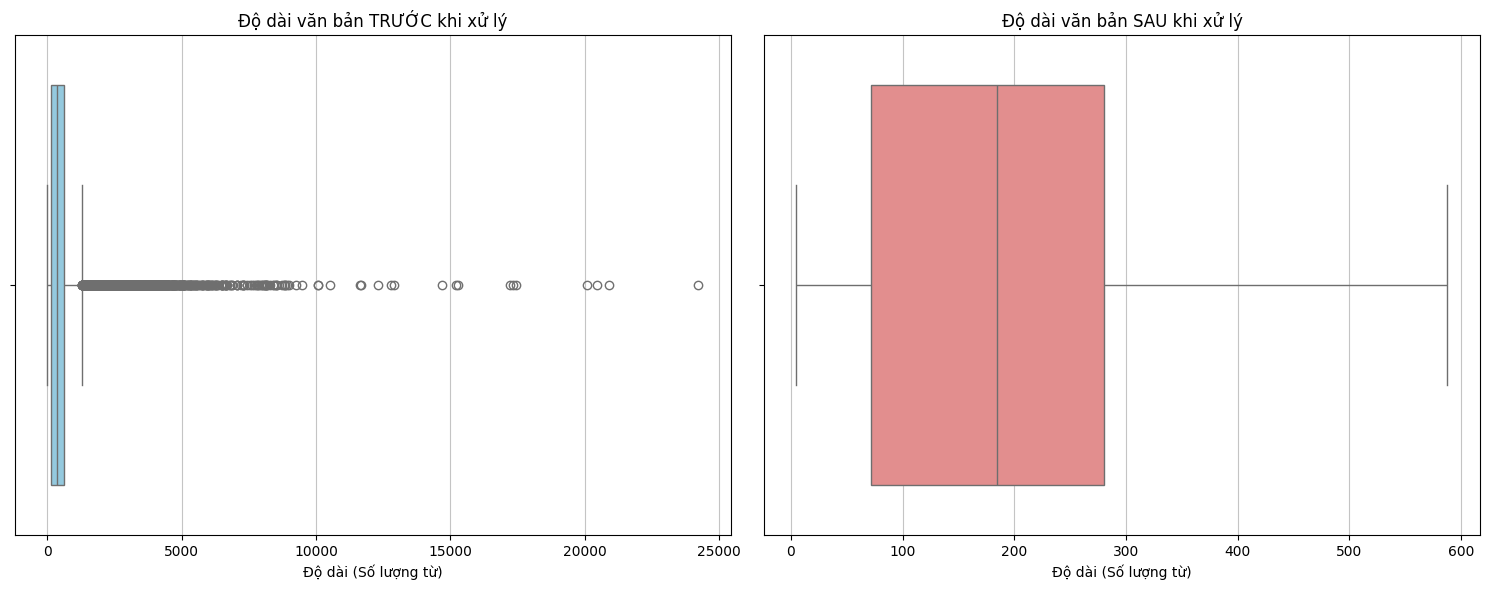

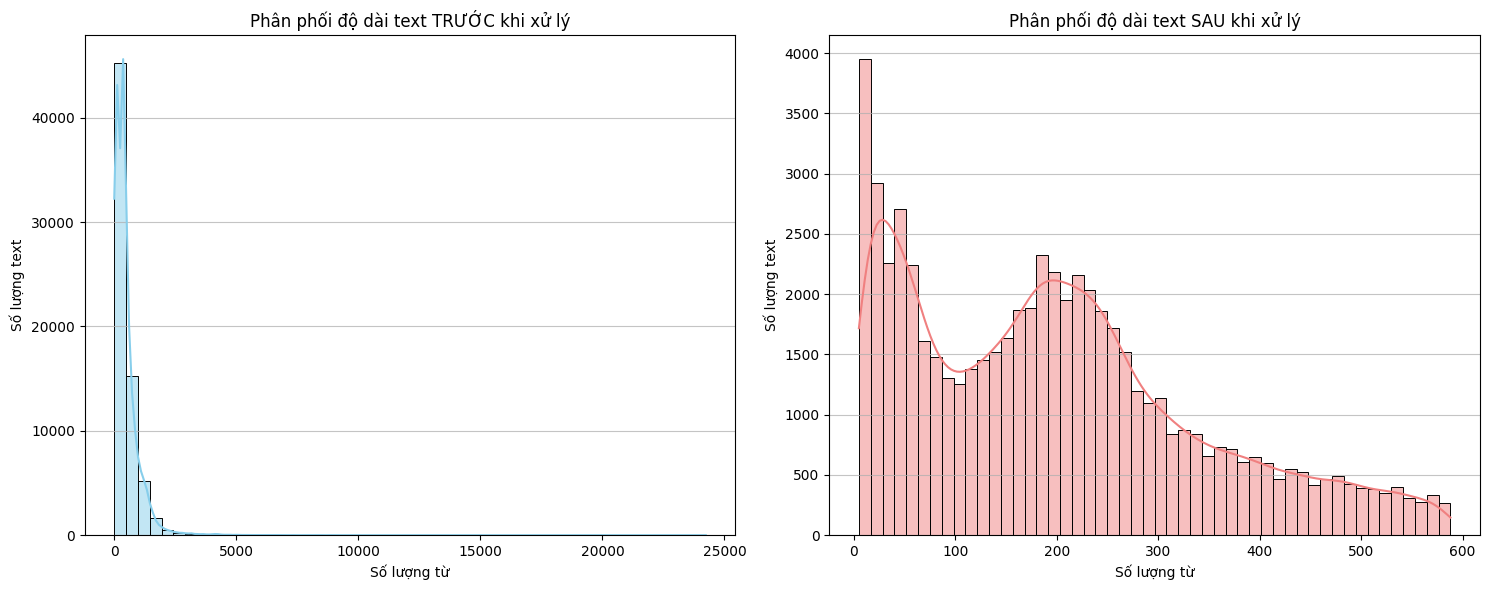

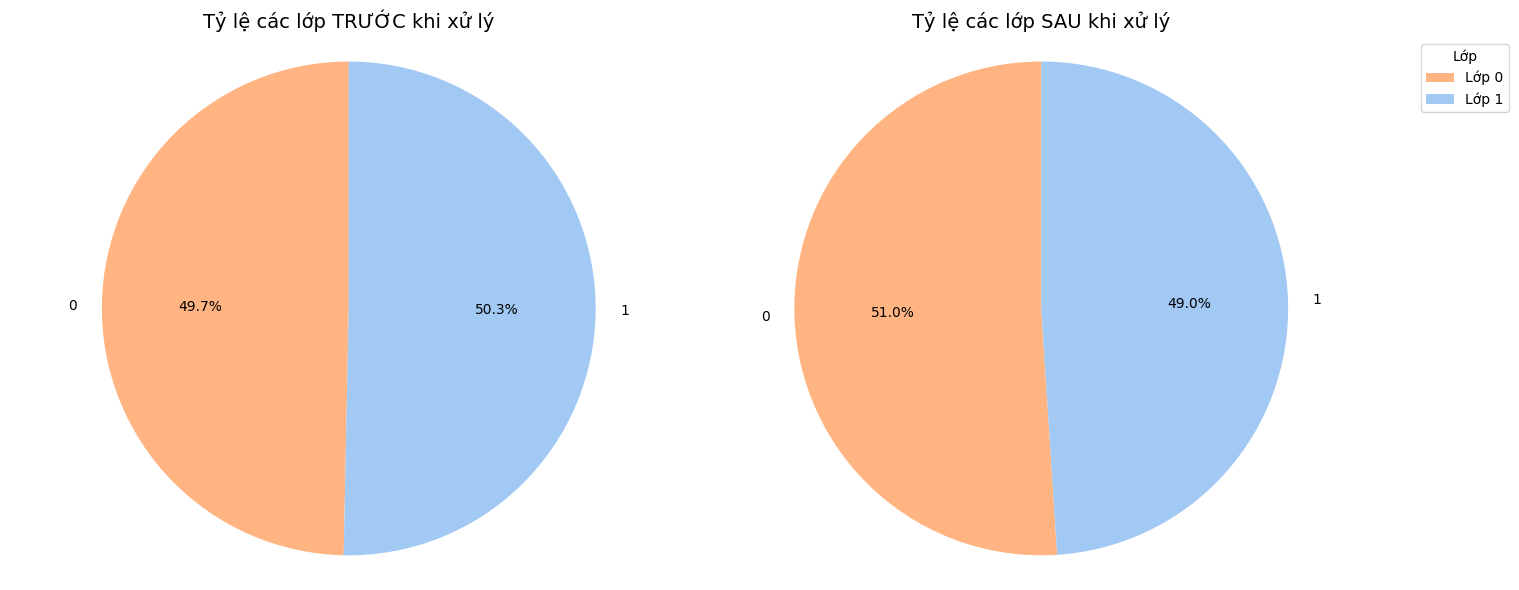

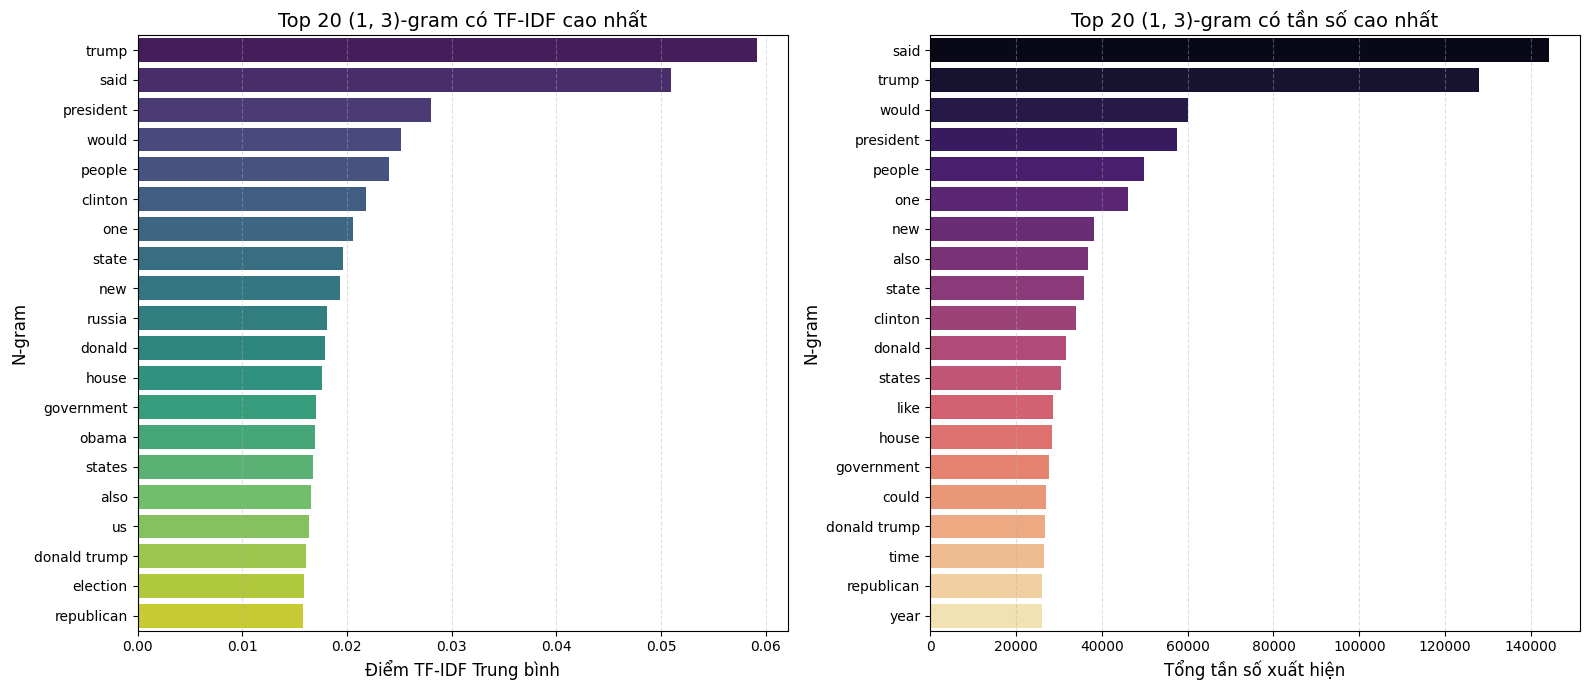

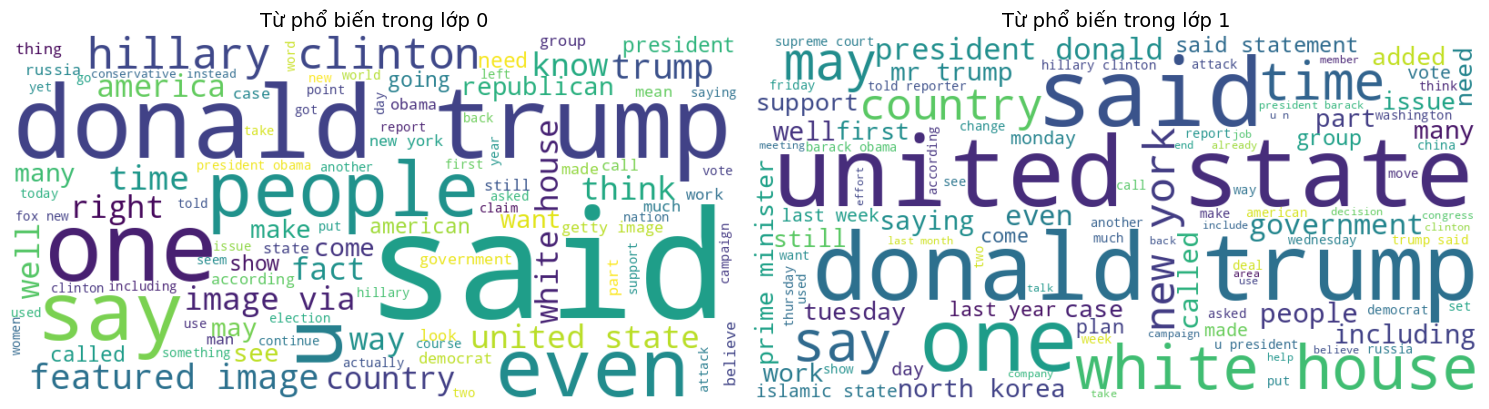

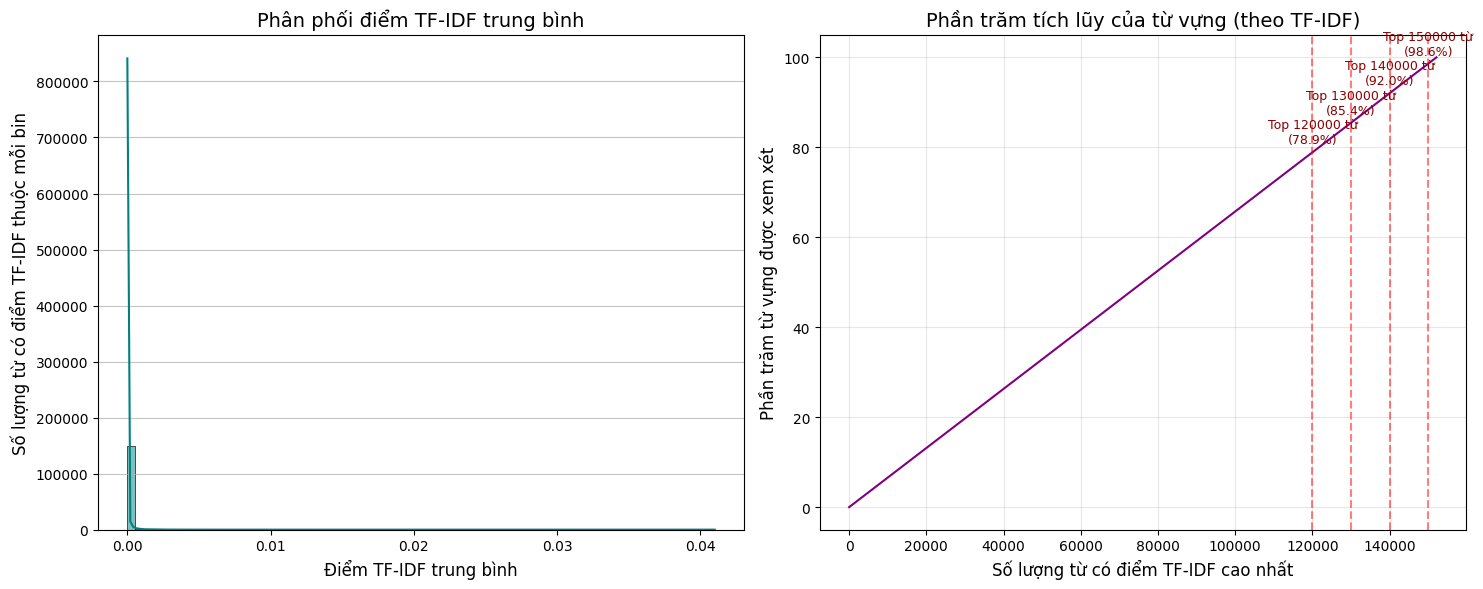

--- Thống kê từ vựng dựa trên TF-IDF ---
Tổng số từ duy nhất trong từ vựng: 152,146
- Top 120,000 từ có điểm TF-IDF cao nhất chiếm 78.9% từ vựng tổng thể.
- Top 130,000 từ có điểm TF-IDF cao nhất chiếm 85.4% từ vựng tổng thể.
- Top 140,000 từ có điểm TF-IDF cao nhất chiếm 92.0% từ vựng tổng thể.
- Top 150,000 từ có điểm TF-IDF cao nhất chiếm 98.6% từ vựng tổng thể.


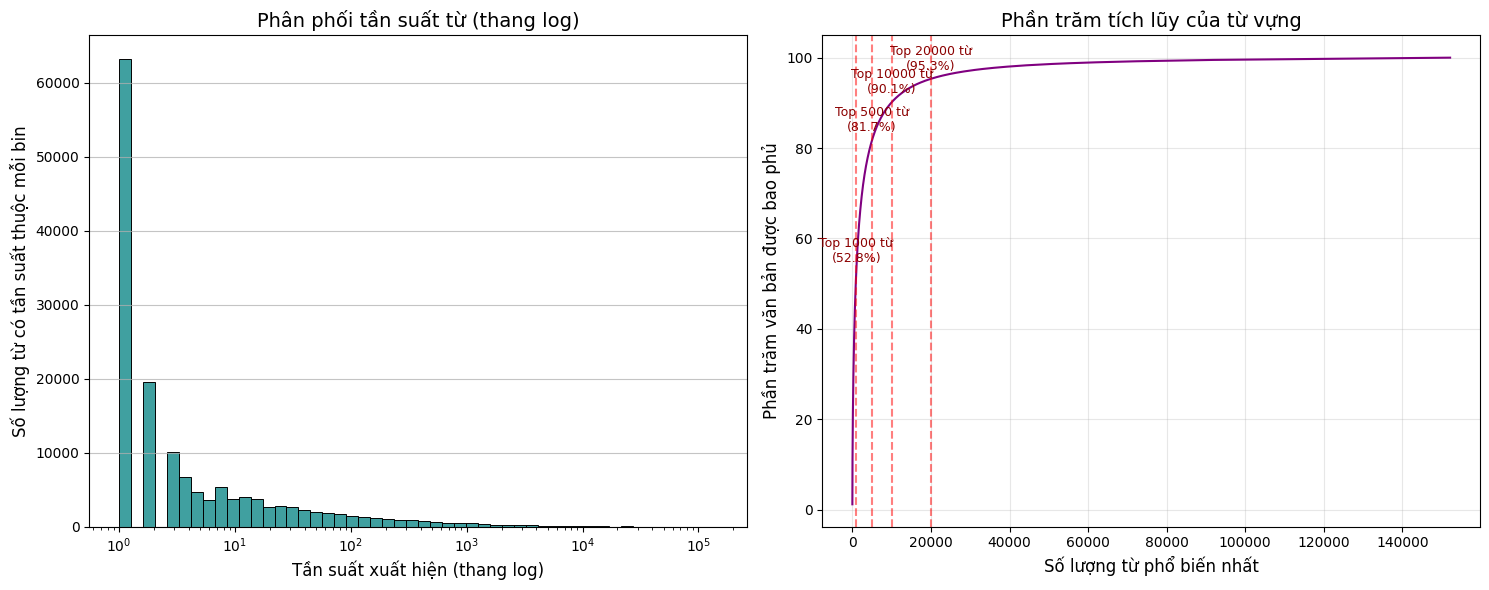

--- Thống kê từ vựng dựa trên mức độ phổ biến ---
Tổng số từ duy nhất trong từ vựng: 152,146
- Top 1,000 từ phổ biến nhất bao phủ 52.8% tổng số từ.
- Top 5,000 từ phổ biến nhất bao phủ 81.7% tổng số từ.
- Top 10,000 từ phổ biến nhất bao phủ 90.1% tổng số từ.
- Top 20,000 từ phổ biến nhất bao phủ 95.3% tổng số từ.


In [ ]:
#------------#------------#------------#------------#------------#------------#------------#------------#
# Thực hiện các bước trực quan hóa
visualizer = Visualizer(dataCollector.df, dataPreprocessor.df_ML)
visualizer.plot_text_length_boxplot()
visualizer.plot_text_length_distribution()
visualizer.plot_class_proportions()
visualizer.plot_top_features()
visualizer.plot_word_clouds()
visualizer.plot_average_tfidf_distribution()
visualizer.plot_word_frequency_distribution()

In [ ]:
#------------#------------#------------#------------#------------#------------#------------#------------#
# Workflow 1: Machine Learning
workflowML = WorkflowML(dataPreprocessor.df_ML[:]) # 31250:31300
workflowML.split_data(test_ratio=0.2, random_seed=42)
# workflowML.find_best_hyperparameters()
workflowML.best_optimized_models = {'LogisticRegression': {'best_estimator': Pipeline(steps=[('vectorizer',
                                                    TfidfVectorizer(max_features=20000, min_df=5,
                                                                    ngram_range=(1, 2))),
                                                    ('lr',
                                                    LogisticRegression(C=10.0, max_iter=1000, random_state=42,
                                                                        solver='liblinear'))])},
                                    'DecisionTreeClassifier': {'best_estimator': Pipeline(steps=[('vectorizer',
                                                    CountVectorizer(max_features=20000, min_df=3,
                                                                    ngram_range=(1, 2))),
                                                    ('dt',
                                                    DecisionTreeClassifier(max_depth=20, min_samples_leaf=2,
                                                                            min_samples_split=10,
                                                                            random_state=42))])},
                                    'MultinomialNB': {'best_estimator': Pipeline(steps=[('vectorizer',
                                                    TfidfVectorizer(max_features=20000, min_df=5,
                                                                    ngram_range=(1, 2))),
                                                    ('mnb', MultinomialNB(alpha=0.5))])},
                                    'RandomForestClassifier': {'best_estimator': Pipeline(steps=[('vectorizer',
                                                    TfidfVectorizer(max_features=20000, min_df=3,
                                                                    ngram_range=(1, 2))),
                                                    ('rf',
                                                    RandomForestClassifier(min_samples_leaf=2,
                                                                            min_samples_split=20, n_jobs=-1,
                                                                            random_state=42))])},
                                    'SVC': {'best_estimator': Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=20000, min_df=10)),
                                                    ('svc',
                                                    SVC(kernel='linear', max_iter=3000, probability=True,
                                                        random_state=42))])}}
for model_pipline_name, hp_info in workflowML.best_optimized_models.items():
    best_pipeline = hp_info['best_estimator']
    workflowML.set_model_pipline(model_pipline_name, best_pipeline)
    workflowML.train_model()
    workflowML.save_model()
    workflowML.evaluate_model()

2025-06-12 09:17:00,857 - INFO - BẮT ĐẦU: Chia dữ liệu thành tập huấn luyện và kiểm tra.
2025-06-12 09:17:00,888 - INFO -    - Tổng số mẫu: 61255
2025-06-12 09:17:00,889 - INFO -    - Kích thước tập Train:   49004 (80.00%)
2025-06-12 09:17:00,889 - INFO -    - Kích thước tập Test:    12251 (20.00%)
2025-06-12 09:17:00,891 - INFO -    - Phân bố lớp trong tập Train:    {0: 0.51, 1: 0.49}
2025-06-12 09:17:00,892 - INFO -    - Phân bố lớp trong tập Test:     {0: 0.51, 1: 0.49}
2025-06-12 09:17:00,892 - INFO - HOÀN TẤT: Chia dữ liệu thành tập huấn luyện và kiểm tra.


2025-06-12 09:17:00,893 - INFO - BẮT ĐẦU: Huấn luyện mô hình 'LogisticRegression'.
2025-06-12 09:17:38,610 - INFO - HOÀN TẤT: Huấn luyện mô hình 'LogisticRegression'.
2025-06-12 09:17:38,689 - INFO - Lưu thành công vào 'pipline LogisticRegression.pkl'.
2025-06-12 09:17:42,042 - INFO - Đánh giá trên tập kiểm tra:
2025-06-12 09:17:42,043 - INFO -     Accuracy      = 0.9550
2025-06-12 09:17:42,043 - INFO -     Precision     = 0.9

In [ ]:
#------------#------------#------------#------------#------------#------------#------------#------------#
# Workflow 2.1: Deep Learning - BERT
hypers = Hyperparameters(
        model_name_or_path='bert-base-cased',
        num_labels=2,
        max_length=384,
        use_sliding_window=True,
        stride=96,
        batch_size=12,
        num_epochs=20,
        early_stopping_patience=3,
        warmup_steps_rate=0.05,
        learning_rate=2e-5,
        adam_epsilon=1e-8,
        save_directory_name = 'pipline bert-base-cased'
    )
workflowDL = WorkflowDL(dataPreprocessor.df_DL[:], hypers) # 31100:31150
workflowDL.split_data(test_ratio=0.15, val_ratio=0.15, random_seed=42)
workflowDL.tokenize_data()
workflowDL.create_data_loaders()
workflowDL.build_load_model()
workflowDL.train_model()
workflowDL.save_pipeline()
workflowDL.evaluate_model()
visualizer.display_model_architecture(workflowDL.model)

2025-06-12 10:03:06,766 - INFO - Khởi tạo Hyperparameters:
2025-06-12 10:03:06,767 - INFO -      - Model Name: bert-base-cased
2025-06-12 10:03:06,767 - INFO -      - Max Length: 384
2025-06-12 10:03:06,768 - INFO -      - Use Sliding Window: True
2025-06-12 10:03:06,768 - INFO -      - Stride: 96
2025-06-12 10:03:06,769 - INFO -      - Batch Size: 12
2025-06-12 10:03:06,769 - INFO -      - Num Epochs: 20
2025-06-12 10:03:06,770 - INFO -      - Early Stopping Patience: 3
2025-06-12 10:03:06,770 - INFO -      - Warmup Steps Rate: 0.05
2025-06-12 10:03:06,771 - INFO -      - Learning Rate: 2e-05
2025-06-12 10:03:06,771 - INFO -      - Adam Epsilon: 1e-08
2025-06-12 10:03:06,771 - INFO -      - Save Directory Name: pipline bert-base-cased
2025-06-12 10:03:06,772 - INFO -      - Device: cuda


2025-06-12 10:03:06,773 - INFO - BẮT ĐẦU: Chia dữ liệu thành tập huấn luyện, xác thực và kiểm tra.
2025-06-12 10:03:06,821 - INFO -     - Tổng số mẫu: 61091
2025-06-12 10:03:06,822 - INFO -     - Kíc

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Tokenizing Train Set:   0%|          | 0/42763 [00:00<?, ?it/s]

Tokenizing Valid Set:   0%|          | 0/9164 [00:00<?, ?it/s]

Tokenizing Test Set:   0%|          | 0/9164 [00:00<?, ?it/s]

2025-06-12 10:05:16,211 - INFO - HOÀN TẤT: Tokenizing với bert-base-cased

.
2025-06-12 10:05:16,213 - INFO - BẮT ĐẦU: Tạo DataLoaders với batch_size=12
2025-06-12 10:05:16,214 - INFO - HOÀN TẤT: Tạo DataLoaders với batch_size=12


2025-06-12 10:05:16,215 - INFO - BẮT ĐẦU: Xây dựng/tải mô hình: bert-base-cased.


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-06-12 10:05:19,163 - INFO - HOÀN TẤT: Xây dựng/tải mô hình: bert-base-cased.


2025-06-12 10:05:19,426 - INFO - BẮT ĐẦU: Huấn luyện mô hình bert-base-cased.
2025-06-12 10:05:19,427 - INFO - --- Epoch 1/20 ---


Epoch huấn luyện:   0%|          | 0/6892 [00:00<?, ?it/s]

2025-06-12 10:48:17,344 - INFO - Epoch 1 Training: Loss=0.1878, Accuracy=0.9351


Epoch đánh giá:   0%|          | 0/1485 [00:00<?, ?it/s]

2025-06-12 10:51:15,495 - INFO - Epoch 1 Validation: Loss=0.1620, Accuracy=0.9638
2025-06-12 10:51:15,498 - INFO - Validation loss cải thiện. Đang lưu trạng thái mô hình tốt nhất (loss: 0.1620).
2025-06-12 10:51:15,499 - INFO - --- Epoch 2/20 ---


Epoch huấn luyện:   0%|          | 0/6892 [00:00<?, ?it/s]

2025-06-12 11:34:13,568 - INFO - Epoch 2 Training: Loss=0.0751, Accuracy=0.9817


Epoch đánh giá:   0%|          | 0/1485 [00:00<?, ?it/s]

2025-06-12 11:37:11,618 - INFO - Epoch 2 Validation: Loss=0.0807, Accuracy=0.9805
2025-06-12 11:37:11,621 - INFO - Validation loss cải thiện. Đang lưu trạng thái mô hình tốt nhất (loss: 0.0807).
2025-06-12 11:37:11,622 - INFO - --- Epoch 3/20 ---


Epoch huấn luyện:   0%|          | 0/6892 [00:00<?, ?it/s]

2025-06-12 12:20:10,082 - INFO - Epoch 3 Training: Loss=0.0376, Accuracy=0.9916


Epoch đánh giá:   0%|          | 0/1485 [00:00<?, ?it/s]

2025-06-12 12:23:08,160 - INFO - Epoch 3 Validation: Loss=0.0919, Accuracy=0.9796
2025-06-12 12:23:08,161 - INFO - Validation loss không cải thiện. Số epoch không cải thiện: 1/3
2025-06-12 12:23:08,162 - INFO - --- Epoch 4/20 ---


Epoch huấn luyện:   0%|          | 0/6892 [00:00<?, ?it/s]

2025-06-12 13:06:06,199 - INFO - Epoch 4 Training: Loss=0.0219, Accuracy=0.9955


Epoch đánh giá:   0%|          | 0/1485 [00:00<?, ?it/s]

2025-06-12 13:09:04,262 - INFO - Epoch 4 Validation: Loss=0.1158, Accuracy=0.9835
2025-06-12 13:09:04,263 - INFO - Validation loss không cải thiện. Số epoch không cải thiện: 2/3
2025-06-12 13:09:04,263 - INFO - --- Epoch 5/20 ---


Epoch huấn luyện:   0%|          | 0/6892 [00:00<?, ?it/s]

2025-06-12 13:52:01,368 - INFO - Epoch 5 Training: Loss=0.0166, Accuracy=0.9969


Epoch đánh giá:   0%|          | 0/1485 [00:00<?, ?it/s]

2025-06-12 13:54:59,467 - INFO - Epoch 5 Validation: Loss=0.1322, Accuracy=0.9809
2025-06-12 13:54:59,468 - INFO - Validation loss không cải thiện. Số epoch không cải thiện: 3/3
2025-06-12 13:54:59,468 - INFO - Kích hoạt dừng sớm (Early Stopping)! Validation loss không cải thiện trong 3 epoch liên tiếp.
2025-06-12 13:54:59,473 - INFO - HOÀN TẤT: Huấn luyện mô hình pipline bert-base-cased.


2025-06-12 13:54:59,477 - INFO - Đã tạo thư mục lưu: pipline bert-base-cased
2025-06-12 13:55:00,531 - INFO - Mô hình đã được lưu thành công tại: pipline bert-base-cased
2025-06-12 13:55:00,561 - INFO - Tokenizer đã được lưu thành công tại: pipline bert-base-cased
2025-06-12 13:55:00,566 - INFO - Siêu tham số đã được lưu tại: pipline bert-base-cased




Đánh giá trên tập kiểm tra:   0%|          | 0/1461 [00:00<?, ?it/s]

2025-06-12 13:57:58,191 - INFO - Đánh giá trên tập kiểm tra:
2025-06-12 13:57:58,192 - INFO -     - Loss      = 0.0319
2025-06-12 13:57:58,192 - INFO -     - Accuracy  = 0.9933
2025-06-12 13:57:58,192 - INFO -     - Precision = 0.9933
2025-06-12 13:57:58,193 - INFO -     - Recall    = 0.9933
2025-06-12 13:57:58,193 - INFO -     - F1 Score  = 0.9933




Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   22,268,928
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

In [ ]:
#------------#------------#------------#------------#------------#------------#------------#------------#
# Workflow 2.2: Deep Learning - XLNET
hypers = Hyperparameters(
        model_name_or_path='xlnet-base-cased',
        num_labels=2,
        max_length=384,
        use_sliding_window=True,
        stride=96,
        batch_size=12,
        num_epochs=20,
        early_stopping_patience=3,
        warmup_steps_rate=0.05,
        learning_rate=2e-5,
        adam_epsilon=1e-8,
        save_directory_name = 'pipline xlnet-base-cased'
    )
workflowDL.hypers = hypers
workflowDL.tokenize_data()
workflowDL.create_data_loaders()
workflowDL.build_load_model()
workflowDL.train_model()
workflowDL.save_pipeline()
workflowDL.evaluate_model()
visualizer.display_model_architecture(workflowDL.model)

2025-06-12 13:57:58,222 - INFO - Khởi tạo Hyperparameters:
2025-06-12 13:57:58,223 - INFO -      - Model Name: xlnet-base-cased
2025-06-12 13:57:58,223 - INFO -      - Max Length: 384
2025-06-12 13:57:58,223 - INFO -      - Use Sliding Window: True
2025-06-12 13:57:58,224 - INFO -      - Stride: 96
2025-06-12 13:57:58,224 - INFO -      - Batch Size: 12
2025-06-12 13:57:58,225 - INFO -      - Num Epochs: 20
2025-06-12 13:57:58,225 - INFO -      - Early Stopping Patience: 3
2025-06-12 13:57:58,225 - INFO -      - Warmup Steps Rate: 0.05
2025-06-12 13:57:58,226 - INFO -      - Learning Rate: 2e-05
2025-06-12 13:57:58,226 - INFO -      - Adam Epsilon: 1e-08
2025-06-12 13:57:58,227 - INFO -      - Save Directory Name: pipline xlnet-base-cased
2025-06-12 13:57:58,227 - INFO -      - Device: cuda


2025-06-12 13:57:58,228 - INFO - BẮT ĐẦU: Tokenizing với xlnet-base-cased.


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Tokenizing Train Set:   0%|          | 0/42763 [00:00<?, ?it/s]

Tokenizing Valid Set:   0%|          | 0/9164 [00:00<?, ?it/s]

Tokenizing Test Set:   0%|          | 0/9164 [00:00<?, ?it/s]

2025-06-12 14:00:31,550 - INFO - HOÀN TẤT: Tokenizing với xlnet-base-cased

.
2025-06-12 14:00:31,551 - INFO - BẮT ĐẦU: Tạo DataLoaders với batch_size=12
2025-06-12 14:00:31,564 - INFO - HOÀN TẤT: Tạo DataLoaders với batch_size=12


2025-06-12 14:00:31,565 - INFO - BẮT ĐẦU: Xây dựng/tải mô hình: xlnet-base-cased.


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-06-12 14:00:34,731 - INFO - HOÀN TẤT: Xây dựng/tải mô hình: xlnet-base-cased.


2025-06-12 14:00:34,872 - INFO - BẮT ĐẦU: Huấn luyện mô hình xlnet-base-cased.
2025-06-12 14:00:34,873 - INFO - --- Epoch 1/20 ---


Epoch huấn luyện:   0%|          | 0/6856 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

2025-06-12 15:21:09,987 - INFO - Epoch 1 Training: Loss=0.1398, Accuracy=0.9531


Epoch đánh giá:   0%|          | 0/1475 [00:00<?, ?it/s]

2025-06-12 15:27:03,673 - INFO - Epoch 1 Validation: Loss=0.0640, Accuracy=0.9830
2025-06-12 15:27:03,675 - INFO - Validation loss cải thiện. Đang lưu trạng thái mô hình tốt nhất (loss: 0.0640).
2025-06-12 15:27:03,675 - INFO - --- Epoch 2/20 ---


Epoch huấn luyện:   0%|          | 0/6856 [00:00<?, ?it/s]

2025-06-12 16:47:37,946 - INFO - Epoch 2 Training: Loss=0.0562, Accuracy=0.9871


Epoch đánh giá:   0%|          | 0/1475 [00:00<?, ?it/s]

2025-06-12 16:53:31,599 - INFO - Epoch 2 Validation: Loss=0.0726, Accuracy=0.9845
2025-06-12 16:53:31,600 - INFO - Validation loss không cải thiện. Số epoch không cải thiện: 1/3
2025-06-12 16:53:31,601 - INFO - --- Epoch 3/20 ---


Epoch huấn luyện:   0%|          | 0/6856 [00:00<?, ?it/s]

2025-06-12 18:14:05,335 - INFO - Epoch 3 Training: Loss=0.0345, Accuracy=0.9929


Epoch đánh giá:   0%|          | 0/1475 [00:00<?, ?it/s]

2025-06-12 18:19:58,586 - INFO - Epoch 3 Validation: Loss=0.0724, Accuracy=0.9862
2025-06-12 18:19:58,587 - INFO - Validation loss không cải thiện. Số epoch không cải thiện: 2/3
2025-06-12 18:19:58,587 - INFO - --- Epoch 4/20 ---


Epoch huấn luyện:   0%|          | 0/6856 [00:00<?, ?it/s]

2025-06-12 19:40:32,362 - INFO - Epoch 4 Training: Loss=0.0247, Accuracy=0.9953


Epoch đánh giá:   0%|          | 0/1475 [00:00<?, ?it/s]

2025-06-12 19:46:25,496 - INFO - Epoch 4 Validation: Loss=0.0835, Accuracy=0.9858
2025-06-12 19:46:25,497 - INFO - Validation loss không cải thiện. Số epoch không cải thiện: 3/3
2025-06-12 19:46:25,498 - INFO - Kích hoạt dừng sớm (Early Stopping)! Validation loss không cải thiện trong 3 epoch liên tiếp.
2025-06-12 19:46:25,503 - INFO - HOÀN TẤT: Huấn luyện mô hình pipline xlnet-base-cased.


2025-06-12 19:46:25,508 - INFO - Đã tạo thư mục lưu: pipline xlnet-base-cased
2025-06-12 19:46:26,538 - INFO - Mô hình đã được lưu thành công tại: pipline xlnet-base-cased
2025-06-12 19:46:26,563 - INFO - Tokenizer đã được lưu thành công tại: pipline xlnet-base-cased
2025-06-12 19:46:26,567 - INFO - Siêu tham số đã được lưu tại: pipline xlnet-base-cased




Đánh giá trên tập kiểm tra:   0%|          | 0/1452 [00:00<?, ?it/s]

2025-06-12 19:52:08,167 - INFO - Đánh giá trên tập kiểm tra:
2025-06-12 19:52:08,168 - INFO -     - Loss      = 0.0317
2025-06-12 19:52:08,168 - INFO -     - Accuracy  = 0.9933
2025-06-12 19:52:08,169 - INFO -     - Precision = 0.9933
2025-06-12 19:52:08,169 - INFO -     - Recall    = 0.9933
2025-06-12 19:52:08,170 - INFO -     - F1 Score  = 0.9933




Layer (type:depth-idx)                             Param #
XLNetForSequenceClassification                     --
├─XLNetModel: 1-1                                  768
│    └─Embedding: 2-1                              24,576,000
│    └─ModuleList: 2-2                             --
│    │    └─XLNetLayer: 3-1                        7,678,464
│    │    └─XLNetLayer: 3-2                        7,678,464
│    │    └─XLNetLayer: 3-3                        7,678,464
│    │    └─XLNetLayer: 3-4                        7,678,464
│    │    └─XLNetLayer: 3-5                        7,678,464
│    │    └─XLNetLayer: 3-6                        7,678,464
│    │    └─XLNetLayer: 3-7                        7,678,464
│    │    └─XLNetLayer: 3-8                        7,678,464
│    │    └─XLNetLayer: 3-9                        7,678,464
│    │    └─XLNetLayer: 3-10                       7,678,464
│    │    └─XLNetLayer: 3-11                       7,678,464
│    │    └─XLNetLayer: 3-12                 

In [ ]:
#------------#------------#------------#------------#------------#------------#------------#------------#
# ModelInferencer
model_paths = [ 'pipline DecisionTreeClassifier.pkl',
                'pipline LogisticRegression.pkl',
                'pipline MultinomialNB.pkl',
                'pipline RandomForestClassifier.pkl',
                'pipline SVC.pkl',
                'pipline bert-base-cased',
                'pipline xlnet-base-cased']
for model_path in model_paths:
    modelInferencer = ModelInferencer(model_path=model_path, df=dataCollector.inference_df)
    inference_results = modelInferencer.infer()

2025-06-12 19:52:08,207 - INFO - ====================================================================================================
2025-06-12 19:52:08,207 - INFO -                     --- KẾT QUẢ DỰ ĐOÁN CHO MÔ HÌNH: DECISIONTREECLASSIFIER ---                     
2025-06-12 19:52:08,207 - INFO - ====================================================================================================
2025-06-12 19:52:08,208 - INFO - Mẫu #1:
2025-06-12 19:52:08,208 - INFO -     Văn bản: S.C. Senator Lindsey Graham has been a shining beacon in the Republican Party wh...
2025-06-12 19:52:08,209 - INFO -     Dự đoán:       0 (FAKE)
2025-06-12 19:52:08,210 - INFO -     Nhãn thực tế:  0 (FAKE)
2025-06-12 19:52:08,210 - INFO -     Xác suất FAKE: 1.0000
2025-06-12 19:52:08,210 - INFO -     Xác suất TRUE: 0.0000
2025-06-12 19:52:08,211 - INFO - ----------------------------------------------------------------------------------------------------
2025-06-12 19:52:08,211 - INFO - Mẫu #2:
2025-06-12 1

Tokenizing Test Set:   0%|          | 0/4 [00:00<?, ?it/s]

Đánh giá trên tập kiểm tra:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-12 19:52:09,136 - INFO - ====================================================================================================
2025-06-12 19:52:09,137 - INFO -                         --- KẾT QUẢ DỰ ĐOÁN CHO MÔ HÌNH: BERT-BASE-CASED ---                        
2025-06-12 19:52:09,137 - INFO - ====================================================================================================
2025-06-12 19:52:09,138 - INFO - Mẫu #1:
2025-06-12 19:52:09,138 - INFO -     Văn bản: S.C. Senator Lindsey Graham has been a shining beacon in the Republican Party wh...
2025-06-12 19:52:09,139 - INFO -     Dự đoán:       0 (FAKE)
2025-06-12 19:52:09,139 - INFO -     Nhãn thực tế:  0 (FAKE)
2025-06-12 19:52:09,141 - INFO -     Xác suất FAKE: 1.0000
2025-06-12 19:52:09,141 - INFO -     Xác suất TRUE: 0.0000
2025-06-12 19:52:09,141 - INFO - ----------------------------------------------------------------------------------------------------
2025-06-12 19:52:09,142 - INFO - Mẫu #2:
2025-06-12 1

Tokenizing Test Set:   0%|          | 0/4 [00:00<?, ?it/s]

Đánh giá trên tập kiểm tra:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-12 19:52:09,810 - INFO - ====================================================================================================
2025-06-12 19:52:09,811 - INFO -                        --- KẾT QUẢ DỰ ĐOÁN CHO MÔ HÌNH: XLNET-BASE-CASED ---                        
2025-06-12 19:52:09,811 - INFO - ====================================================================================================
2025-06-12 19:52:09,812 - INFO - Mẫu #1:
2025-06-12 19:52:09,812 - INFO -     Văn bản: S.C. Senator Lindsey Graham has been a shining beacon in the Republican Party wh...
2025-06-12 19:52:09,813 - INFO -     Dự đoán:       0 (FAKE)
2025-06-12 19:52:09,813 - INFO -     Nhãn thực tế:  0 (FAKE)
2025-06-12 19:52:09,814 - INFO -     Xác suất FAKE: 0.9999
2025-06-12 19:52:09,814 - INFO -     Xác suất TRUE: 0.0001
2025-06-12 19:52:09,815 - INFO - ----------------------------------------------------------------------------------------------------
2025-06-12 19:52:09,815 - INFO - Mẫu #2:
2025-06-12 1

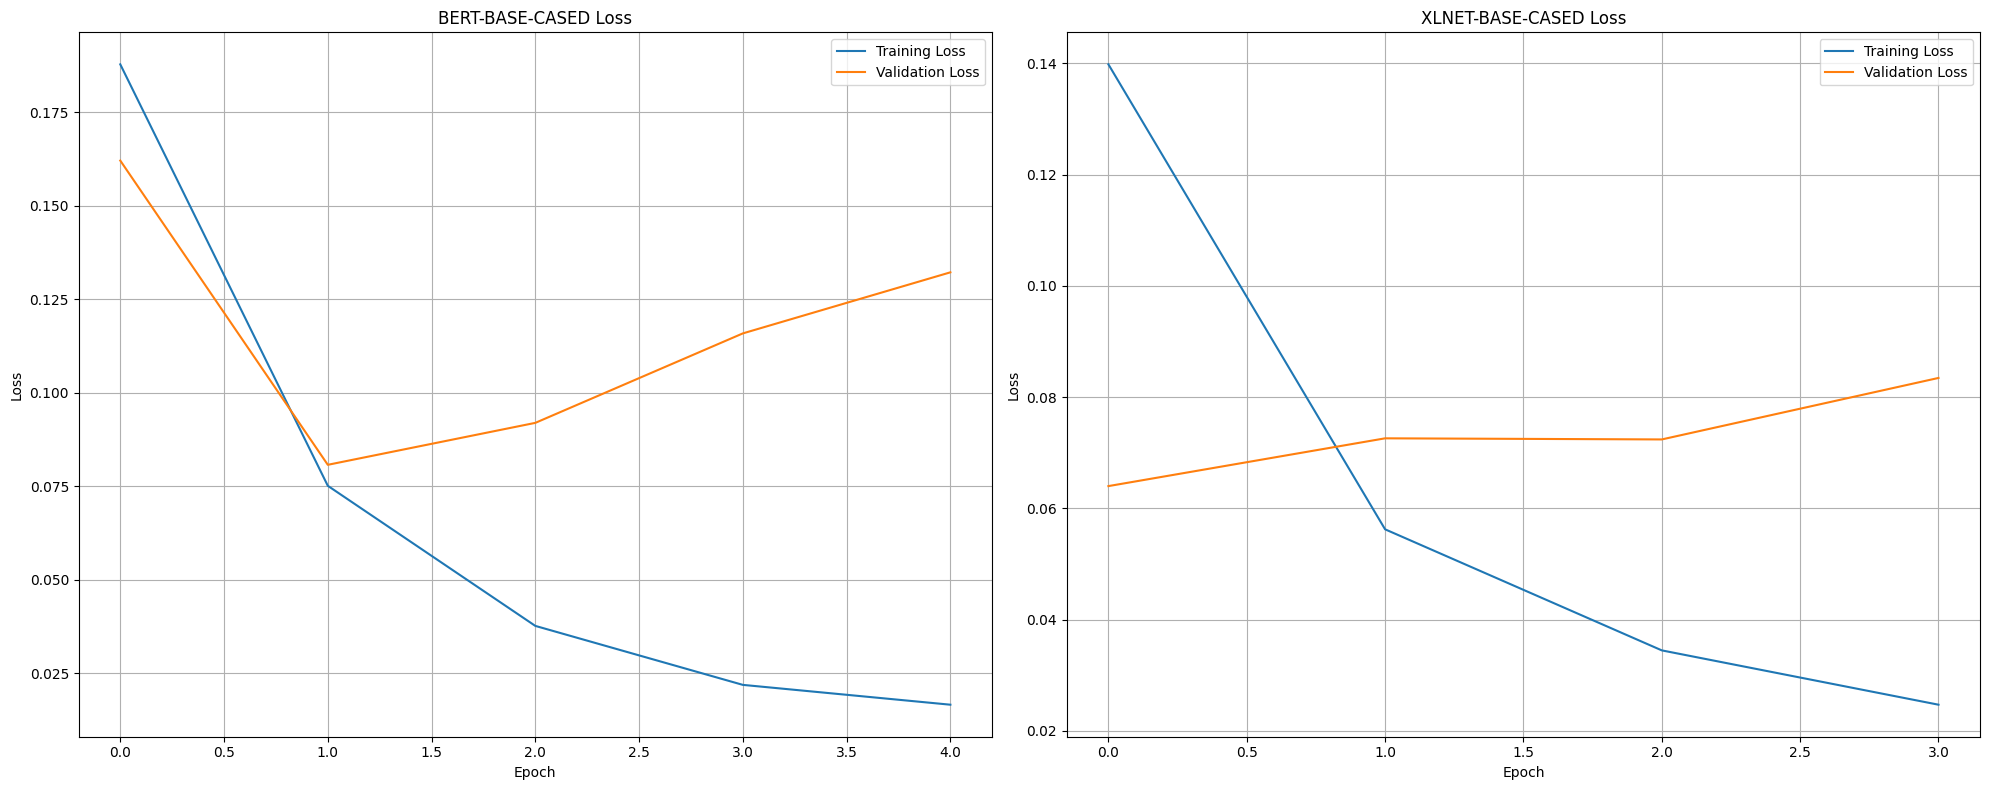

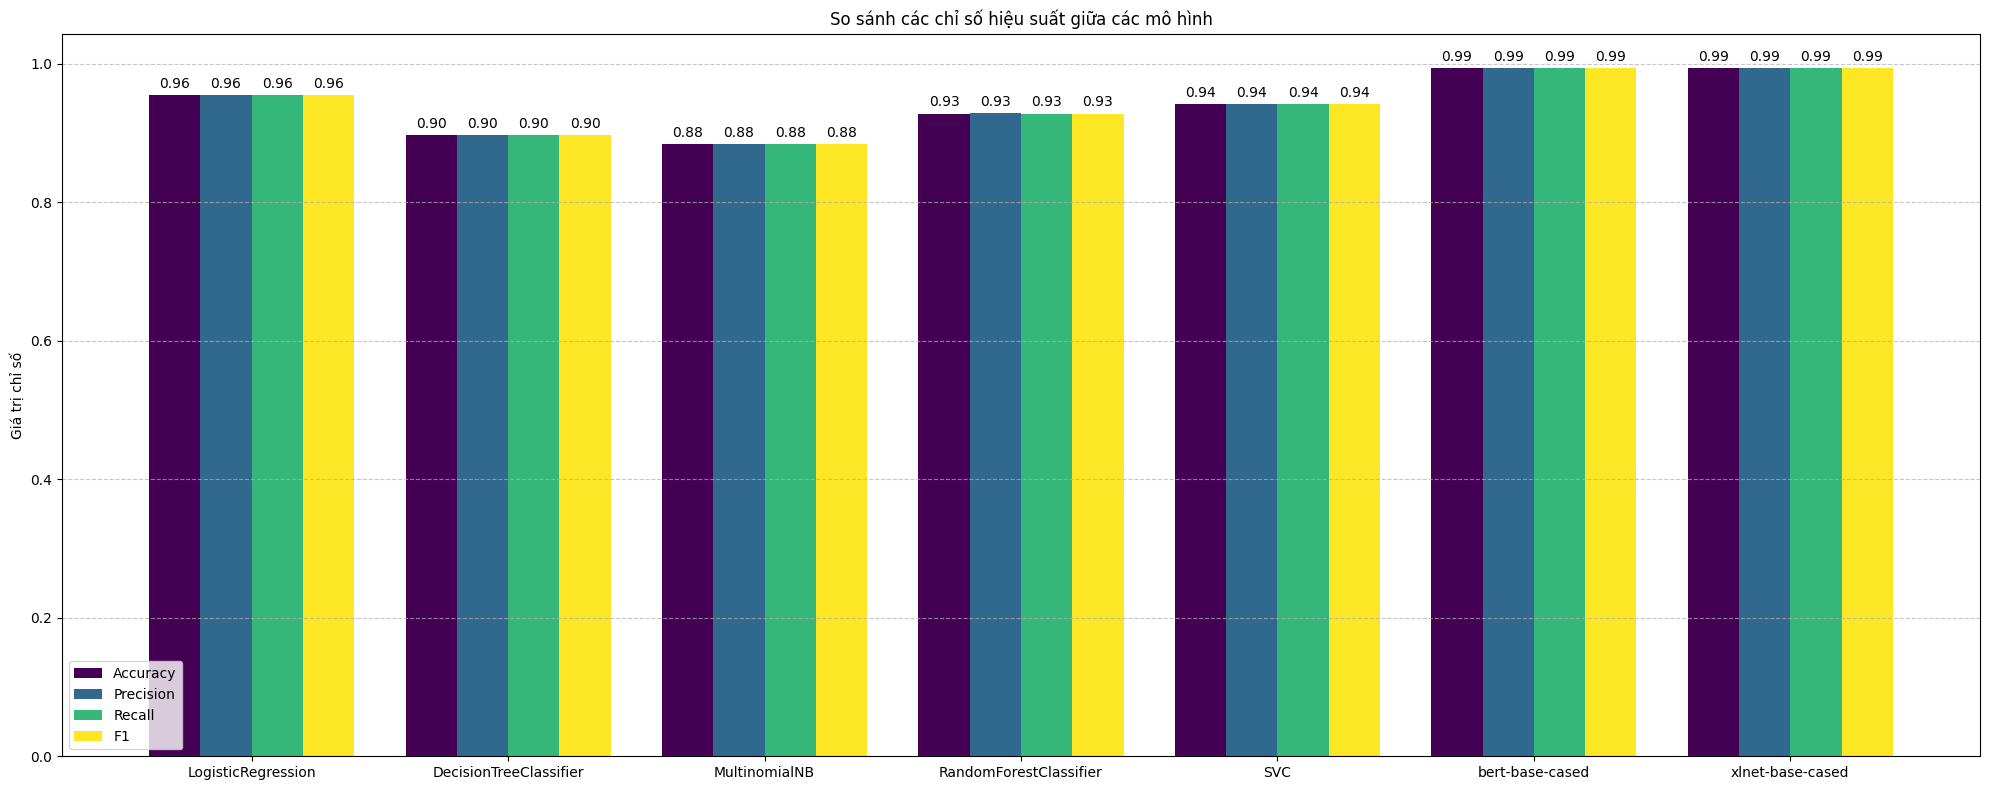

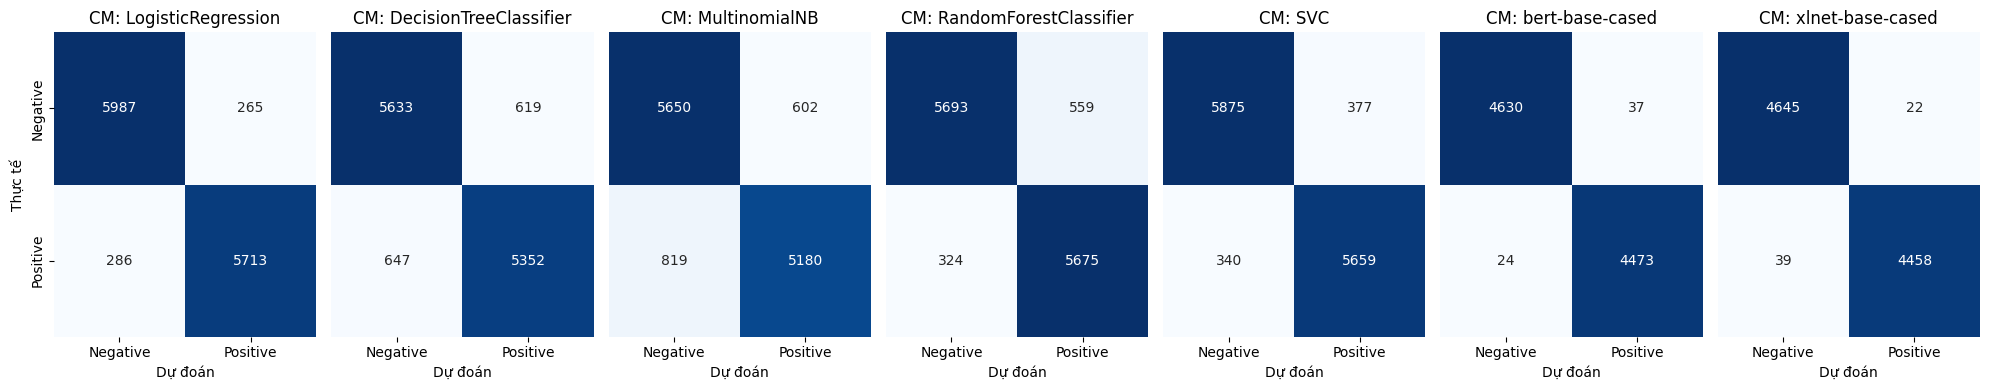

In [ ]:
visualizer.evaluation_results = {**workflowML.evaluation_results, **workflowDL.evaluation_results}
visualizer.plot_all_loss_curves()
visualizer.plot_evaluation_results()
visualizer.plot_confusion_matrices()

In [ ]:
visualizer.display_evaluation_results()

2025-06-12 19:52:12,032 - INFO - TẤT CẢ KẾT QUẢ ĐÁNH GIÁ CỦA CÁC MÔ HÌNH
2025-06-12 19:52:12,033 - INFO - ========================================
2025-06-12 19:52:12,034 - INFO - Mô hình: LOGISTICREGRESSION
2025-06-12 19:52:12,034 - INFO - ----------------------------------------
2025-06-12 19:52:12,035 - INFO -    Accuracy  : 0.9550
2025-06-12 19:52:12,035 - INFO -    Precision : 0.9550
2025-06-12 19:52:12,036 - INFO -    Recall    : 0.9550
2025-06-12 19:52:12,036 - INFO -    F1        : 0.9550
2025-06-12 19:52:12,037 - INFO - ----------------------------------------
2025-06-12 19:52:12,038 - INFO - Mô hình: DECISIONTREECLASSIFIER
2025-06-12 19:52:12,039 - INFO - ----------------------------------------
2025-06-12 19:52:12,039 - INFO -    Accuracy  : 0.8967
2025-06-12 19:52:12,040 - INFO -    Precision : 0.8967
2025-06-12 19:52:12,040 - INFO -    Recall    : 0.8967
2025-06-12 19:52:12,041 - INFO -    F1        : 0.8967
2025-06-12 19:52:12,041 - INFO - --------------------------------